# 1. Data Loading

In [1]:
# ============================================================
# CELL 1 — Environment Setup + Reproducibility + Config (UPDATED)
# Goal:
# - Support "global split" (use all patches, not scene-only split)
# - Allow controlled sampling of fire vs non-fire before splitting
# - Keep variable names stable for later cells
# ============================================================

import os, glob, random, json, time
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

# ----------------------------
# 1) Reproducibility / Seed
# ----------------------------
def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # deterministic behavior (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

# ----------------------------
# 2) Device
# ----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ----------------------------
# 3) Config
# ----------------------------
@dataclass
class CFG:
    # Dataset root folder
    DATA_ROOT: str = "/kaggle/input/sen2fire/Sen2Fire"

    # Scenes in dataset (still used for file listing)
    SCENES: Tuple[str, ...] = ("scene1", "scene2", "scene3", "scene4")

    # file extension for patches
    PATCH_EXT: str = ".npz"

    # ============================
    # SPLIT STRATEGY
    # ============================
    # If True: ignore paper's scene split, do GLOBAL split from all patches.
    USE_GLOBAL_SPLIT: bool = True

    # Global split ratios (must sum to 1.0)
    GLOBAL_TRAIN_RATIO: float = 0.80
    GLOBAL_VAL_RATIO: float = 0.10
    GLOBAL_TEST_RATIO: float = 0.10

    # If False: use paper split by scenes (kept for compatibility)
    TRAIN_SCENES: Tuple[str, ...] = ("scene1", "scene2")
    VAL_SCENES: Tuple[str, ...] = ("scene3",)
    TEST_SCENES: Tuple[str, ...] = ("scene4",)

    # ============================
    # LABEL SETTINGS
    # ============================
    X_KEY: str = "image"
    Y_KEY: str = "label"
    A_KEY: str = "aerosol"

    # Define "fire patch": fire pixel ratio > this threshold
    # (0.0 means: any positive pixel counts as fire patch)
    FIRE_PATCH_MIN_RATIO: float = 0.0

    # ============================
    # SAMPLING STRATEGY (BEFORE SPLIT)
    # ============================
    # If True: you can purposely select a subset from full 2466 patches
    # to control fire/non-fire counts (e.g., 1:1 or 1:3).
    USE_CONTROLLED_POOL: bool = True

    # How many FIRE patches to keep in the pool.
    # -1 means keep ALL fire patches found.
    POOL_KEEP_FIRE: int = -1

    # How many NON-FIRE patches to keep relative to fire in the pool.
    # Example:
    #   NONFIRE_PER_FIRE = 1  -> 1:1
    #   NONFIRE_PER_FIRE = 3  -> 1:3 (more natural)
    NONFIRE_PER_FIRE: int = 3

    # If True: validation/test use NATURAL distribution (recommended),
    # meaning controlled pool applies mainly to train.
    # (Cell 2 will handle this if enabled.)
    KEEP_VAL_TEST_NATURAL: bool = True

    # ============================
    # SMALL SAMPLE MODE (debug)
    # ============================
    USE_SMALL_SAMPLE: bool = False
    SMALL_SAMPLE_TRAIN: int = 200
    SMALL_SAMPLE_VAL: int = 60
    SMALL_SAMPLE_TEST: int = 60

    # Debug prints
    VERBOSE: bool = True

cfg = CFG()

# ----------------------------
# 4) Helper: list patch files
# ----------------------------
def list_scene_files(data_root: str, scene_name: str, ext: str = ".npz") -> List[str]:
    scene_dir = os.path.join(data_root, scene_name)
    pattern = os.path.join(scene_dir, f"*{ext}")
    files = sorted(glob.glob(pattern))
    return files

def assert_exists(path: str, name: str = "path") -> None:
    if not os.path.exists(path):
        raise FileNotFoundError(f"{name} not found: {path}")

assert_exists(cfg.DATA_ROOT, "cfg.DATA_ROOT")
print("DATA_ROOT OK:", cfg.DATA_ROOT)

# ----------------------------
# 5) Helper: inspect npz structure
# ----------------------------
def inspect_npz(npz_path: str, max_print: int = 20) -> Dict[str, Tuple[Tuple[int, ...], str]]:
    """
    Returns dictionary:
      key -> (shape, dtype)
    """
    with np.load(npz_path) as data:
        keys = list(data.keys())
        info = {}
        for k in keys[:max_print]:
            arr = data[k]
            info[k] = (arr.shape, str(arr.dtype))
    return info

print("\nCFG summary:")
print("  USE_GLOBAL_SPLIT:", cfg.USE_GLOBAL_SPLIT)
print("  GLOBAL ratios   :", cfg.GLOBAL_TRAIN_RATIO, cfg.GLOBAL_VAL_RATIO, cfg.GLOBAL_TEST_RATIO)
print("  USE_CONTROLLED_POOL:", cfg.USE_CONTROLLED_POOL)
print("  POOL_KEEP_FIRE      :", cfg.POOL_KEEP_FIRE)
print("  NONFIRE_PER_FIRE    :", cfg.NONFIRE_PER_FIRE)
print("  KEEP_VAL_TEST_NATURAL:", cfg.KEEP_VAL_TEST_NATURAL)
print("  USE_SMALL_SAMPLE    :", cfg.USE_SMALL_SAMPLE)

Device: cuda
DATA_ROOT OK: /kaggle/input/sen2fire/Sen2Fire

CFG summary:
  USE_GLOBAL_SPLIT: True
  GLOBAL ratios   : 0.8 0.1 0.1
  USE_CONTROLLED_POOL: True
  POOL_KEEP_FIRE      : -1
  NONFIRE_PER_FIRE    : 3
  KEEP_VAL_TEST_NATURAL: True
  USE_SMALL_SAMPLE    : False


In [2]:
# ============================================================
# CELL 2 — Build FULL Manifest (2466) + has_fire scan
#          + Controlled Train Pool + Global Stratified Split
# Output:
#   - train_paths, val_paths, test_paths (same names as before)
#   - manifest CSVs saved for auditability
# Notes:
#   - If cfg.KEEP_VAL_TEST_NATURAL=True:
#       * VAL/TEST are sampled from FULL NATURAL distribution (stratified)
#       * TRAIN is built from remaining data, then controlled pool is applied
# ============================================================

import os
import numpy as np
import pandas as pd

# ----------------------------
# 0) Safety checks
# ----------------------------
assert abs((cfg.GLOBAL_TRAIN_RATIO + cfg.GLOBAL_VAL_RATIO + cfg.GLOBAL_TEST_RATIO) - 1.0) < 1e-6, \
    "GLOBAL split ratios must sum to 1.0"

# ----------------------------
# 1) Gather ALL files across scenes
# ----------------------------
scene_to_files = {}
total = 0

for s in cfg.SCENES:
    files = list_scene_files(cfg.DATA_ROOT, s, cfg.PATCH_EXT)
    scene_to_files[s] = files
    total += len(files)
    print(f"{s}: {len(files)} patches")

print("Total patches:", total)

if total == 0:
    raise RuntimeError("No patch files found. Check cfg.DATA_ROOT and cfg.PATCH_EXT.")

# ----------------------------
# 2) Build full manifest dataframe
# ----------------------------
rows = []
for s, files in scene_to_files.items():
    for p in files:
        rows.append({"scene": s, "path": p})
manifest = pd.DataFrame(rows)

if cfg.VERBOSE:
    display(manifest.head())
    display(manifest["scene"].value_counts())

# ----------------------------
# 3) Inspect one file for keys/shapes (avoid silent mismatch)
# ----------------------------
sample_path = manifest.iloc[0]["path"]
print("\nSample file:", sample_path)

info = inspect_npz(sample_path)
print("NPZ keys (shape, dtype):")
for k, (shape, dtype) in info.items():
    print(f"  - {k:>15s}: shape={shape}, dtype={dtype}")

# Quick key availability check
required_keys = [cfg.X_KEY, cfg.Y_KEY]
for rk in required_keys:
    if rk not in info:
        raise KeyError(f"Required key '{rk}' not found in NPZ keys: {list(info.keys())}")

# ----------------------------
# 4) Define has_fire for each patch (fast scan)
#    has_fire = 1 if fire_pixel_ratio > cfg.FIRE_PATCH_MIN_RATIO
# ----------------------------
def fire_ratio_from_path(npz_path, label_key=cfg.Y_KEY):
    with np.load(npz_path) as data:
        y = data[label_key]
        # handle (H,W) or (H,W,1)
        if y.ndim == 3 and y.shape[-1] == 1:
            y = y[..., 0]
        yb = (y > 0).astype(np.uint8)
        return float(yb.mean())

# Scan all patches
fire_ratios = []
has_fire = []

for p in manifest["path"].tolist():
    r = fire_ratio_from_path(p, cfg.Y_KEY)
    fire_ratios.append(r)
    has_fire.append(1 if r > cfg.FIRE_PATCH_MIN_RATIO else 0)

manifest["fire_ratio"] = fire_ratios
manifest["has_fire"] = has_fire

print("\nFULL dataset has_fire distribution:")
counts_full = manifest["has_fire"].value_counts().sort_index()
ratios_full = (manifest["has_fire"].value_counts(normalize=True).sort_index())
print(counts_full)
print("\nFULL dataset has_fire ratio:")
print(ratios_full)

# ----------------------------
# 5) Global stratified split helper
# ----------------------------
def stratified_split(df, train_ratio, val_ratio, test_ratio, seed=42):
    """
    Stratified by has_fire. Returns train_df, val_df, test_df
    """
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)  # shuffle

    # Split within each class, then concat
    parts = []
    for cls in [0, 1]:
        sub = df[df["has_fire"] == cls].copy()
        n = len(sub)
        n_train = int(round(n * train_ratio))
        n_val = int(round(n * val_ratio))
        # rest is test
        n_test = n - n_train - n_val

        sub_train = sub.iloc[:n_train]
        sub_val   = sub.iloc[n_train:n_train+n_val]
        sub_test  = sub.iloc[n_train+n_val:]

        parts.append((sub_train, sub_val, sub_test))

    train_df = pd.concat([parts[0][0], parts[1][0]]).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    val_df   = pd.concat([parts[0][1], parts[1][1]]).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    test_df  = pd.concat([parts[0][2], parts[1][2]]).sample(frac=1.0, random_state=seed).reset_index(drop=True)

    return train_df, val_df, test_df

# ----------------------------
# 6) Build VAL/TEST (natural) + TRAIN pool (remaining)
# ----------------------------
if cfg.USE_GLOBAL_SPLIT:
    if cfg.KEEP_VAL_TEST_NATURAL:
        # Step A: make NATURAL val/test via stratified split on full dataset
        train_tmp, val_df, test_df = stratified_split(
            manifest,
            train_ratio=cfg.GLOBAL_TRAIN_RATIO,
            val_ratio=cfg.GLOBAL_VAL_RATIO,
            test_ratio=cfg.GLOBAL_TEST_RATIO,
            seed=SEED
        )

        # train_tmp is the remainder pool BEFORE controlled sampling
        train_pool_df = train_tmp.copy()

        print("\nGLOBAL split (NATURAL val/test) counts:")
        print("  Train pool:", len(train_pool_df))
        print("  Val      :", len(val_df))
        print("  Test     :", len(test_df))

    else:
        # All splits from same distribution, no special treatment
        train_pool_df, val_df, test_df = stratified_split(
            manifest,
            train_ratio=cfg.GLOBAL_TRAIN_RATIO,
            val_ratio=cfg.GLOBAL_VAL_RATIO,
            test_ratio=cfg.GLOBAL_TEST_RATIO,
            seed=SEED
        )
        print("\nGLOBAL stratified split counts:")
        print("  Train:", len(train_pool_df))
        print("  Val  :", len(val_df))
        print("  Test :", len(test_df))
else:
    # fallback: paper split
    train_pool_df = manifest[manifest["scene"].isin(cfg.TRAIN_SCENES)].reset_index(drop=True)
    val_df        = manifest[manifest["scene"].isin(cfg.VAL_SCENES)].reset_index(drop=True)
    test_df       = manifest[manifest["scene"].isin(cfg.TEST_SCENES)].reset_index(drop=True)
    print("\nPaper (scene) split counts:")
    print("  Train pool:", len(train_pool_df))
    print("  Val      :", len(val_df))
    print("  Test     :", len(test_df))

# ----------------------------
# 7) Apply CONTROLLED POOL to TRAIN ONLY (recommended)
#    - keep all fire patches (or up to cfg.POOL_KEEP_FIRE)
#    - keep N*fire non-fire patches (cfg.NONFIRE_PER_FIRE)
# ----------------------------
if cfg.USE_CONTROLLED_POOL:
    fire_df = train_pool_df[train_pool_df["has_fire"] == 1].copy()
    nofire_df = train_pool_df[train_pool_df["has_fire"] == 0].copy()

    n_fire_total = len(fire_df)
    n_nofire_total = len(nofire_df)

    # How many fire to keep
    if cfg.POOL_KEEP_FIRE is None or cfg.POOL_KEEP_FIRE == -1:
        n_fire_keep = n_fire_total
    else:
        n_fire_keep = min(cfg.POOL_KEEP_FIRE, n_fire_total)

    fire_keep = fire_df.sample(n=n_fire_keep, random_state=SEED) if n_fire_keep > 0 else fire_df.iloc[:0]

    # How many nonfire to keep relative to fire
    n_nofire_keep = min(n_nofire_total, n_fire_keep * int(cfg.NONFIRE_PER_FIRE))
    nofire_keep = nofire_df.sample(n=n_nofire_keep, random_state=SEED) if n_nofire_keep > 0 else nofire_df.iloc[:0]

    train_df = pd.concat([fire_keep, nofire_keep]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    print("\nTRAIN pool controlled sampling:")
    print(f"  fire_total_in_pool   : {n_fire_total}")
    print(f"  nofire_total_in_pool : {n_nofire_total}")
    print(f"  fire_kept            : {len(fire_keep)}")
    print(f"  nofire_kept          : {len(nofire_keep)} (NONFIRE_PER_FIRE={cfg.NONFIRE_PER_FIRE})")
    print(f"  train_final          : {len(train_df)}")

else:
    train_df = train_pool_df.copy()
    print("\nTRAIN uses NATURAL pool (no controlled sampling):", len(train_df))

# Show has_fire distributions for transparency
print("\nTrain has_fire distribution (FINAL train_df):")
counts_train = train_df["has_fire"].value_counts().sort_index()
ratios_train = train_df["has_fire"].value_counts(normalize=True).sort_index()
print(counts_train)
print("\nTrain has_fire ratio:")
print(ratios_train)

print("\nVal has_fire distribution:")
print(val_df["has_fire"].value_counts().sort_index())
print("\nTest has_fire distribution:")
print(test_df["has_fire"].value_counts().sort_index())

# ----------------------------
# 8) Optional: small sample mode (after the final split)
# ----------------------------
def take_sample_stratified(df: pd.DataFrame, n: int, seed: int = 42) -> pd.DataFrame:
    if len(df) <= n:
        return df.copy()
    # sample stratified by has_fire
    df0 = df[df["has_fire"] == 0]
    df1 = df[df["has_fire"] == 1]
    # preserve ratio in df
    r1 = len(df1) / max(len(df), 1)
    n1 = int(round(n * r1))
    n0 = n - n1
    # ensure at least 1 positive if possible
    if len(df1) > 0 and n1 == 0:
        n1 = 1
        n0 = n - 1
    n1 = min(n1, len(df1))
    n0 = min(n0, len(df0))
    out = pd.concat([
        df1.sample(n=n1, random_state=seed) if n1 > 0 else df1.iloc[:0],
        df0.sample(n=n0, random_state=seed) if n0 > 0 else df0.iloc[:0],
    ]).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out

if cfg.USE_SMALL_SAMPLE:
    print("\nUsing SMALL SAMPLE:")
    train_df_s = take_sample_stratified(train_df, cfg.SMALL_SAMPLE_TRAIN, SEED)
    val_df_s   = take_sample_stratified(val_df, cfg.SMALL_SAMPLE_VAL, SEED)
    test_df_s  = take_sample_stratified(test_df, cfg.SMALL_SAMPLE_TEST, SEED)

    print("  Train:", len(train_df_s))
    print("  Val  :", len(val_df_s))
    print("  Test :", len(test_df_s))
else:
    train_df_s, val_df_s, test_df_s = train_df, val_df, test_df

# ----------------------------
# 9) Store to python lists for later Dataset class (same variable names)
# ----------------------------
train_paths = train_df_s["path"].tolist()
val_paths   = val_df_s["path"].tolist()
test_paths  = test_df_s["path"].tolist()

# ----------------------------
# 10) Overlap checks (must be 0)
# ----------------------------
overlap_tv = set(train_paths).intersection(set(val_paths))
overlap_tt = set(train_paths).intersection(set(test_paths))
overlap_vt = set(val_paths).intersection(set(test_paths))

print("\nOverlap checks (must be 0):")
print("  train ∩ val :", len(overlap_tv))
print("  train ∩ test:", len(overlap_tt))
print("  val   ∩ test:", len(overlap_vt))

assert len(overlap_tv) == 0 and len(overlap_tt) == 0 and len(overlap_vt) == 0, "Split leakage detected!"

# ----------------------------
# 11) Save manifests for auditability
# ----------------------------
OUT_DIR = "./artifacts_sen2fire"
os.makedirs(OUT_DIR, exist_ok=True)

manifest.to_csv(os.path.join(OUT_DIR, "manifest_all_with_has_fire.csv"), index=False)
train_df.to_csv(os.path.join(OUT_DIR, "manifest_train_full.csv"), index=False)
val_df.to_csv(os.path.join(OUT_DIR, "manifest_val_full.csv"), index=False)
test_df.to_csv(os.path.join(OUT_DIR, "manifest_test_full.csv"), index=False)

# also save final sample (if small sample mode) for reproducibility
train_df_s.to_csv(os.path.join(OUT_DIR, "manifest_train_used.csv"), index=False)
val_df_s.to_csv(os.path.join(OUT_DIR, "manifest_val_used.csv"), index=False)
test_df_s.to_csv(os.path.join(OUT_DIR, "manifest_test_used.csv"), index=False)

print("\nSaved manifests to:", OUT_DIR)
print("  - manifest_all_with_has_fire.csv")
print("  - manifest_train_full.csv / manifest_val_full.csv / manifest_test_full.csv")
print("  - manifest_train_used.csv / manifest_val_used.csv / manifest_test_used.csv")

scene1: 864 patches
scene2: 594 patches
scene3: 504 patches
scene4: 504 patches
Total patches: 2466


scene                                               path
0  scene1  /kaggle/input/sen2fire/Sen2Fire/scene1/scene_1...
1  scene1  /kaggle/input/sen2fire/Sen2Fire/scene1/scene_1...
2  scene1  /kaggle/input/sen2fire/Sen2Fire/scene1/scene_1...
3  scene1  /kaggle/input/sen2fire/Sen2Fire/scene1/scene_1...
4  scene1  /kaggle/input/sen2fire/Sen2Fire/scene1/scene_1...

scene
scene1    864
scene2    594
scene3    504
scene4    504
Name: count, dtype: int64


Sample file: /kaggle/input/sen2fire/Sen2Fire/scene1/scene_1_patch_10_1.npz
NPZ keys (shape, dtype):
  -           image: shape=(12, 512, 512), dtype=int16
  -         aerosol: shape=(512, 512), dtype=float32
  -           label: shape=(512, 512), dtype=uint8

FULL dataset has_fire distribution:
has_fire
0    2117
1     349
Name: count, dtype: int64

FULL dataset has_fire ratio:
has_fire
0    0.858475
1    0.141525
Name: proportion, dtype: float64

GLOBAL split (NATURAL val/test) counts:
  Train pool: 1973
  Val      : 247
  Test     : 246

TRAIN pool controlled sampling:
  fire_total_in_pool   : 279
  nofire_total_in_pool : 1694
  fire_kept            : 279
  nofire_kept          : 837 (NONFIRE_PER_FIRE=3)
  train_final          : 1116

Train has_fire distribution (FINAL train_df):
has_fire
0    837
1    279
Name: count, dtype: int64

Train has_fire ratio:
has_fire
0    0.75
1    0.25
Name: proportion, dtype: float64

Val has_fire distribution:
has_fire
0    212
1     35
Name: count, 

# 2. Data Quality

Sample path: /kaggle/input/sen2fire/Sen2Fire/scene1/scene_1_patch_10_1.npz
Meta: {'x_key': 'image', 'y_key': 'label', 'a_key': 'aerosol', 'x_shape': (12, 512, 512), 'x_dtype': 'int16', 'y_shape': (512, 512), 'a_shape': (512, 512), 'keys': ['image', 'aerosol', 'label'], 'x_transposed_CHW_to_HWC': True}


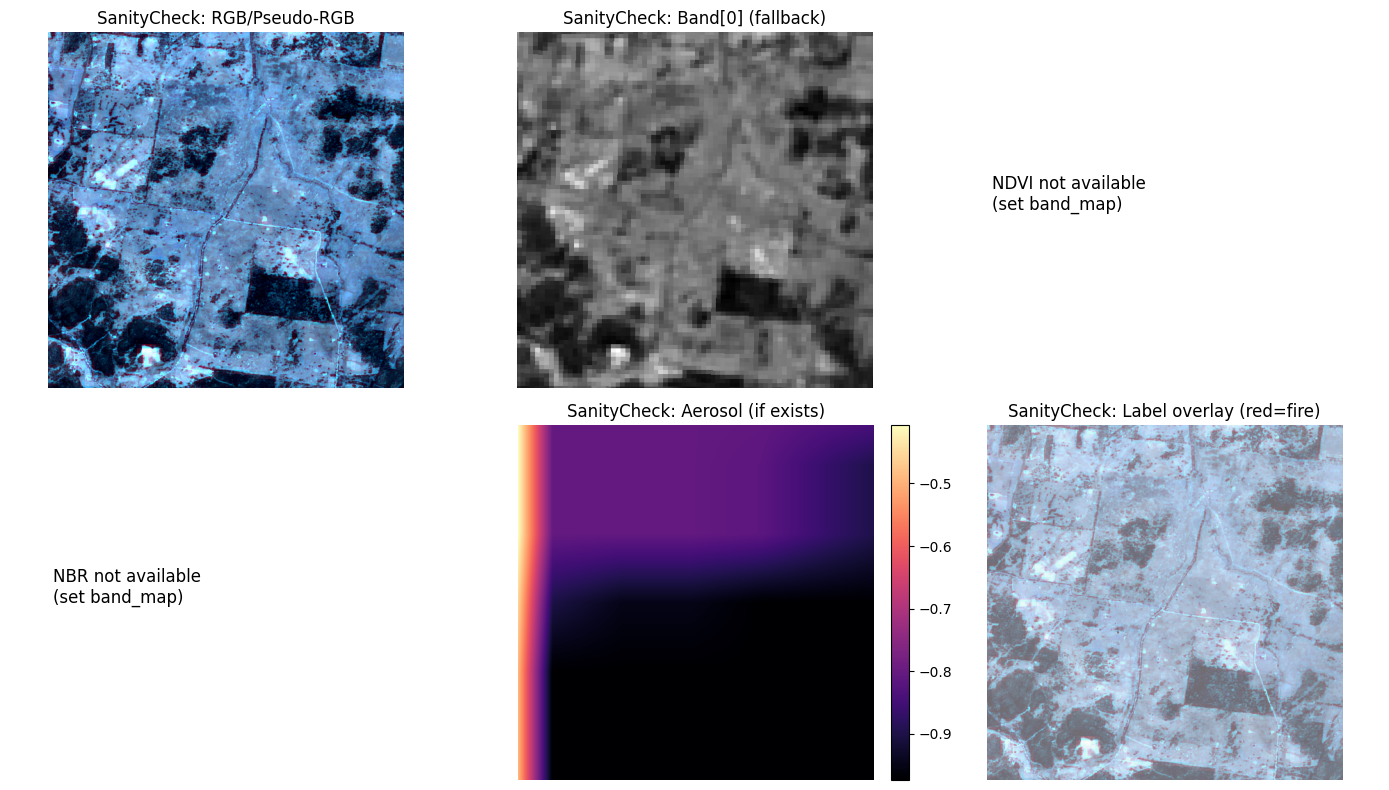

In [3]:
# ============================================================
# CELL 3 — Data Loader (1 patch) + Visualization Utilities
# Goal: verify shapes, band order, label alignment
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Helper: find likely keys ----------
def pick_key(npz_obj, candidates):
    keys = list(npz_obj.keys())
    for c in candidates:
        if c in keys:
            return c
    return None

# ---------- Helper: load one patch ----------
def load_patch(npz_path: str):
    """
    Returns:
      x: np.ndarray (H, W, C)  multispectral or composite
      y: np.ndarray (H, W)     binary mask (0/1) if exists, else None
      a: np.ndarray (H, W)     aerosol if exists, else None
      meta: dict              debugging info
    """
    with np.load(npz_path) as data:
        # Common naming guesses (you may need to adjust)
        x_key = pick_key(data, ["x", "image", "img", "s2", "sentinel2", "patch"])
        y_key = pick_key(data, ["y", "mask", "label", "labels", "gt"])
        a_key = pick_key(data, ["aerosol", "s5p", "ai", "a"])

        if x_key is None:
            raise KeyError(f"Cannot find image key in npz. Available keys: {list(data.keys())}")

        x = data[x_key]
        y = data[y_key] if y_key is not None else None
        a = data[a_key] if a_key is not None else None

        meta = {
            "x_key": x_key, "y_key": y_key, "a_key": a_key,
            "x_shape": x.shape, "x_dtype": str(x.dtype),
            "y_shape": None if y is None else y.shape,
            "a_shape": None if a is None else a.shape,
            "keys": list(data.keys())
        }

    # Normalize shape to (H, W, C)
    # Some datasets store (C, H, W)
    if x.ndim == 3 and x.shape[0] in [10, 11, 12, 13] and x.shape[0] < x.shape[-1]:
        # likely CHW -> HWC
        x = np.transpose(x, (1, 2, 0))
        meta["x_transposed_CHW_to_HWC"] = True
    else:
        meta["x_transposed_CHW_to_HWC"] = False

    # Ensure y is (H, W)
    if y is not None and y.ndim == 3:
        # sometimes stored as (H, W, 1)
        if y.shape[-1] == 1:
            y = y[..., 0]
        else:
            # fallback: take first channel
            y = y[..., 0]

    # Ensure aerosol is (H, W)
    if a is not None and a.ndim == 3:
        if a.shape[-1] == 1:
            a = a[..., 0]
        else:
            a = a[..., 0]

    return x, y, a, meta

# ---------- Helper: safe band indexing ----------
def get_band(x_hwc, idx):
    if x_hwc is None:
        return None
    if idx < 0 or idx >= x_hwc.shape[-1]:
        return None
    return x_hwc[..., idx]

# ---------- Indices: NDVI and NBR ----------
def compute_ndvi(nir, red, eps=1e-6):
    return (nir - red) / (nir + red + eps)

def compute_nbr(nir, swir, eps=1e-6):
    return (nir - swir) / (nir + swir + eps)

# ---------- Visualization ----------
def to_rgb_composite(x, r_idx, g_idx, b_idx, clip_percentiles=(2, 98)):
    """
    x: (H,W,C) float/int
    returns rgb uint8 (H,W,3)
    """
    r = get_band(x, r_idx)
    g = get_band(x, g_idx)
    b = get_band(x, b_idx)
    if (r is None) or (g is None) or (b is None):
        return None

    rgb = np.stack([r, g, b], axis=-1).astype(np.float32)

    # Percentile clipping for nicer visualization
    lo, hi = np.percentile(rgb, clip_percentiles[0]), np.percentile(rgb, clip_percentiles[1])
    rgb = np.clip((rgb - lo) / (hi - lo + 1e-6), 0, 1)
    rgb = (rgb * 255).astype(np.uint8)
    return rgb

def show_patch_views(x, y=None, a=None, band_map=None, title_prefix=""):
    """
    band_map expects indices for standard S2 bands if your x uses that order.
    Example band_map (if x is 12 bands of S2 L2A without cirrus):
      B2=0,B3=1,B4=2,B8=3,B11=10,B12=11 (THIS IS JUST EXAMPLE; MUST MATCH YOUR DATA)
    If you don't know, we'll just show first 3 bands as pseudo-RGB.
    """
    H, W, C = x.shape
    band_map = band_map or {}

    # Try to build RGB using known mapping; fallback to first 3 channels
    # NOTE: S2 true RGB uses B4,B3,B2 (red, green, blue)
    r_idx = band_map.get("B4", 0)
    g_idx = band_map.get("B3", 1)
    b_idx = band_map.get("B2", 2)

    rgb = to_rgb_composite(x, r_idx, g_idx, b_idx)
    if rgb is None:
        rgb = to_rgb_composite(x, 0, 1, 2)

    # SWIR composite often uses (B12, B8, B4) for visualization
    swir_idx = band_map.get("B12", None)
    nir_idx  = band_map.get("B8", None)
    red_idx  = band_map.get("B4", None)

    swir_rgb = None
    if (swir_idx is not None) and (nir_idx is not None) and (red_idx is not None):
        swir_rgb = to_rgb_composite(x, swir_idx, nir_idx, red_idx)

    # NDVI / NBR if possible
    ndvi = None
    nbr = None
    if (nir_idx is not None) and (red_idx is not None):
        ndvi = compute_ndvi(get_band(x, nir_idx).astype(np.float32),
                            get_band(x, red_idx).astype(np.float32))
    if (nir_idx is not None) and (swir_idx is not None):
        nbr = compute_nbr(get_band(x, nir_idx).astype(np.float32),
                          get_band(x, swir_idx).astype(np.float32))

    # Plot grid
    ncols = 3
    nrows = 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8))
    axes = axes.ravel()

    axes[0].imshow(rgb)
    axes[0].set_title(f"{title_prefix}RGB/Pseudo-RGB")
    axes[0].axis("off")

    if swir_rgb is not None:
        axes[1].imshow(swir_rgb)
        axes[1].set_title(f"{title_prefix}SWIR composite (B12,B8,B4)")
        axes[1].axis("off")
    else:
        axes[1].imshow(x[..., 0], cmap="gray")
        axes[1].set_title(f"{title_prefix}Band[0] (fallback)")
        axes[1].axis("off")

    if ndvi is not None:
        im = axes[2].imshow(ndvi, cmap="RdYlGn")
        axes[2].set_title(f"{title_prefix}NDVI")
        axes[2].axis("off")
        plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    else:
        axes[2].text(0.1, 0.5, "NDVI not available\n(set band_map)", fontsize=12)
        axes[2].axis("off")

    if nbr is not None:
        im = axes[3].imshow(nbr, cmap="coolwarm")
        axes[3].set_title(f"{title_prefix}NBR")
        axes[3].axis("off")
        plt.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)
    else:
        axes[3].text(0.1, 0.5, "NBR not available\n(set band_map)", fontsize=12)
        axes[3].axis("off")

    if a is not None:
        im = axes[4].imshow(a, cmap="magma")
        axes[4].set_title(f"{title_prefix}Aerosol (if exists)")
        axes[4].axis("off")
        plt.colorbar(im, ax=axes[4], fraction=0.046, pad=0.04)
    else:
        axes[4].text(0.1, 0.5, "Aerosol not found\n(optional)", fontsize=12)
        axes[4].axis("off")

    # Label + overlay
    if y is not None:
        axes[5].imshow(rgb)
        axes[5].imshow(y, alpha=0.45, cmap="Reds")  # overlay
        axes[5].set_title(f"{title_prefix}Label overlay (red=fire)")
        axes[5].axis("off")
    else:
        axes[5].text(0.1, 0.5, "Label not found\n(check key names)", fontsize=12)
        axes[5].axis("off")

    plt.tight_layout()
    plt.show()


# ---------- Run sanity check on one sample ----------
# (Use train_paths / val_paths / test_paths created earlier, or your own list)

sample_path = train_paths[0] if len(train_paths) > 0 else None
print("Sample path:", sample_path)

x, y, a, meta = load_patch(sample_path)
print("Meta:", meta)

# IMPORTANT: band_map must match your dataset's channel order.
# If you don't know yet, leave empty {} first and we inspect visually.
band_map = {}  # we'll fill this after you confirm channel order
show_patch_views(x, y=y, a=a, band_map=band_map, title_prefix="SanityCheck: ")


#### Penjelasan cell 3
Sebelum masuk ke tahap training model, kami melakukan *sanity check* untuk memastikan bahwa:
1. Struktur data `.npz` terbaca dengan benar (key dan shape sesuai).
2. Citra multispektral dan label memiliki ukuran spasial yang konsisten (tidak offset).
3. Nilai data masuk akal (tidak seluruhnya nol / tidak NaN / tidak terbalik).
4. Kanal aerosol tersedia dan dapat divisualisasikan sebagai layer tambahan.

Sanity check ini penting untuk menghindari kesalahan fatal seperti:
- band/channel tertukar (misalnya red dianggap NIR)
- label bergeser atau tidak sejajar dengan citra
- data label kosong atau salah format
- perbedaan resolusi yang tidak ditangani

Dari output metadata:

- **File**: `/kaggle/input/sen2fire/Sen2Fire/scene2/...patch_4_7.npz`
- **Keys dalam .npz**: `['image', 'aerosol', 'label']`
- **Shape image awal**: `(12, 512, 512)` (format **CHW**)
- **Shape label**: `(512, 512)`
- **Shape aerosol**: `(512, 512)`
- **Dtype image**: `int16`

Informasi:
- Terdapat **12 kanal Sentinel-2** (`image`) dan **1 kanal aerosol** (`aerosol`) sebagai input.
- Label tersedia dan memiliki resolusi spasial yang sama dengan patch (512×512).
- Ini menunjukkan dataset patch siap diproses sebagai tugas segmentasi (pixel-wise).

#### Mengapa dilakukan transpose CHW → HWC?
File `image` tersimpan dalam format **(C, H, W)** yaitu:
- C = jumlah kanal/band (12)
- H, W = ukuran patch (512×512)

Untuk keperluan visualisasi dan beberapa pipeline preprocessing, kita ubah ke format **(H, W, C)** agar:
- mudah membangun komposit RGB
- mudah mengambil band tertentu dengan indexing `x[..., idx]`
- konsisten dengan pemrosesan visual (matplotlib / OpenCV)

Transposisi ini tidak mengubah isi data, hanya mengubah urutan dimensi.

#### Bagaimana `.npz` diubah menjadi gambar yang bisa dilihat?
Karena data Sentinel-2 bersifat multispektral (bukan foto RGB biasa), maka untuk visualisasi kita membuat *komposit*:

- **RGB composite**: mengambil 3 band yang mewakili kanal merah/hijau/biru, lalu:
  - melakukan *percentile clipping* (misalnya 2–98%) untuk mengurangi efek outlier
  - melakukan normalisasi nilai menjadi 0–255
  - hasilnya ditampilkan sebagai gambar RGB

#### Apa yang divalidasi dari hasil gambar?
Dari tampilan hasil:

##### (a) Dimensi dan alignment
Label overlay (warna merah = fire) terlihat berada **di atas patch yang sama**, tidak terpisah/offset.
Karena `label` dan `image` sama-sama berukuran 512×512, overlay dapat dilakukan tanpa resize.
Ini mengindikasikan **tidak ada mismatch resolusi dalam patch**.

##### (b) Data tidak kosong
- Citra multispektral terlihat memiliki variasi tekstur/kontras: artinya data bukan semua nol.
- Aerosol layer menunjukkan gradasi nilai (bukan satu warna datar): artinya layer aerosol benar-benar berisi informasi.
- Label overlay pada patch ini tampak sangat sedikit atau bahkan tidak terlihat jelas. Hal ini karena dataset wildfire yang kita lakukan terdapat distribusi class yang **imbalance** (banyak patch dengan sedikit pixel fire/1)

##### (c) Ketersediaan kanal aerosol dan label
Keys `image`, `aerosol`, dan `label` lengkap, sehingga eksperimen "dengan aerosol vs tanpa aerosol" dapat dilakukan.

# Flag 1 - Loading cukup lama (boleh di skip saja agar tidak makan waktu)

Loaded: /kaggle/input/sen2fire/Sen2Fire/scene1/scene_1_patch_10_1.npz
Image HWC shape: (512, 512, 12) | dtype: int16


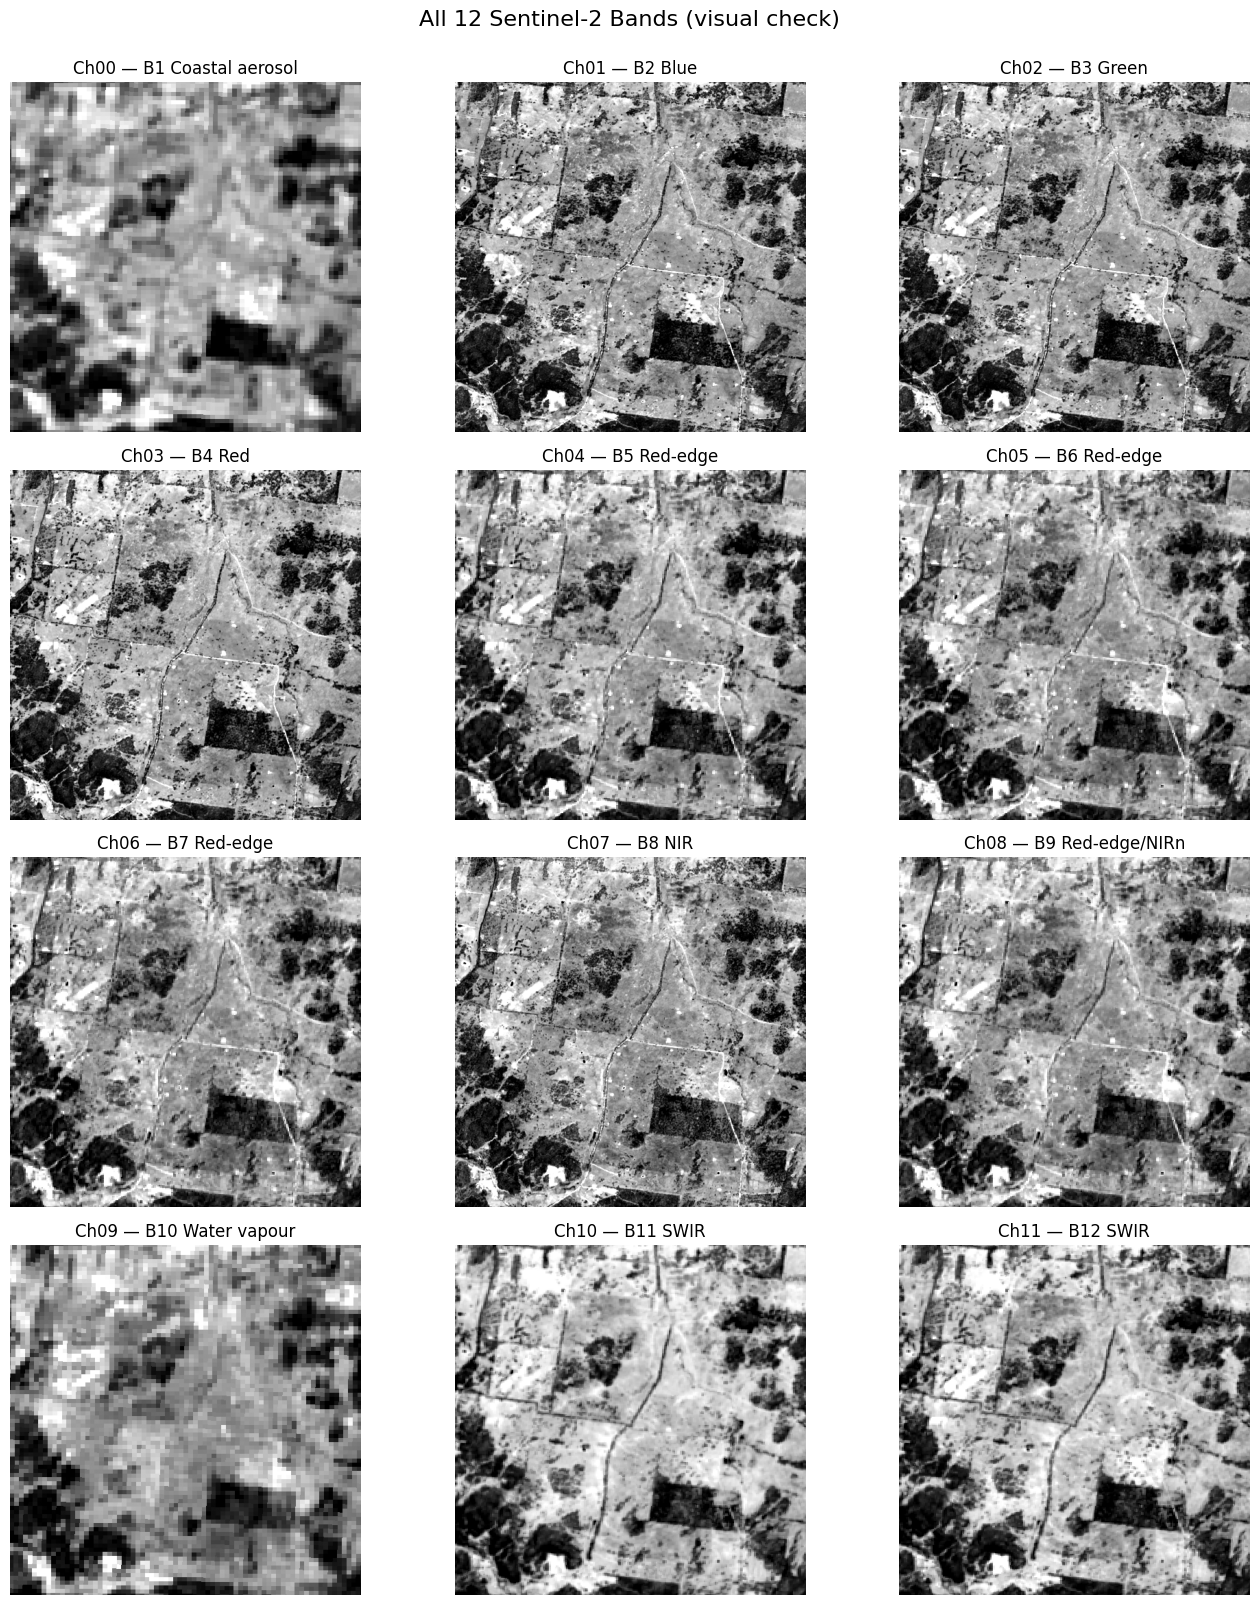

In [4]:
# ============================================================
# CELL 3.2 — Show all 12 bands (4x3 grid)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Optional: mapping index -> band name (assuming channel order follows Table 1)
# NOTE: This assumes image channels are ordered as B1..B12.
band_names = [
    "B1 Coastal aerosol", "B2 Blue", "B3 Green", "B4 Red",
    "B5 Red-edge", "B6 Red-edge", "B7 Red-edge", "B8 NIR",
    "B9 Red-edge/NIRn", "B10 Water vapour", "B11 SWIR", "B12 SWIR"
]

def normalize_for_view(img2d, p_low=2, p_high=98):
    """Percentile stretch for visualization"""
    vmin, vmax = np.percentile(img2d, p_low), np.percentile(img2d, p_high)
    out = (img2d - vmin) / (vmax - vmin + 1e-6)
    return np.clip(out, 0, 1)

def show_all_bands_4x3(x_hwc, title="All 12 Sentinel-2 Bands (visual check)"):
    assert x_hwc.ndim == 3, "Expected HWC"
    H, W, C = x_hwc.shape
    assert C == 12, f"Expected 12 channels, got {C}"

    fig, axes = plt.subplots(4, 3, figsize=(14, 16))
    axes = axes.ravel()

    for i in range(12):
        band = x_hwc[..., i].astype(np.float32)
        band_viz = normalize_for_view(band)

        axes[i].imshow(band_viz, cmap="gray")
        axes[i].set_title(f"Ch{i:02d} — {band_names[i]}")
        axes[i].axis("off")

    plt.suptitle(title, y=1, fontsize=16)
    plt.tight_layout()
    plt.show()

# Run for the same sample
x, y, a, meta = load_patch(sample_path)
print("Loaded:", sample_path)
print("Image HWC shape:", x.shape, "| dtype:", x.dtype)
show_all_bands_4x3(x)

In [5]:
# ============================================================
# CELL 3.5 — Band Statistics + Quality Flags
# ============================================================

import numpy as np
import pandas as pd

def band_stats(x_hwc):
    """
    Compute per-channel stats to detect weird channels:
    - min/max/mean/std
    - %zeros
    - unique ratio (rough indicator)
    """
    H, W, C = x_hwc.shape
    rows = []

    for c in range(C):
        arr = x_hwc[..., c].astype(np.float32)
        rows.append({
            "channel": c,
            "band_name": band_names[c] if c < len(band_names) else f"Ch{c}",
            "min": float(np.min(arr)),
            "p01": float(np.percentile(arr, 1)),
            "mean": float(np.mean(arr)),
            "p99": float(np.percentile(arr, 99)),
            "max": float(np.max(arr)),
            "std": float(np.std(arr)),
            "pct_zeros": float((arr == 0).mean() * 100.0),
        })

    return pd.DataFrame(rows)

def label_stats(y):
    if y is None:
        return {"label_exists": False}
    y_bin = (y > 0).astype(np.uint8)
    return {
        "label_exists": True,
        "shape": y.shape,
        "fire_pixels": int(y_bin.sum()),
        "total_pixels": int(y_bin.size),
        "fire_ratio": float(y_bin.mean()),
        "unique_values": np.unique(y).tolist()[:20],
    }

# Compute stats
x, y, a, meta = load_patch(sample_path)
df_stats = band_stats(x)
display(df_stats)

# Quality flags (heuristic)
# You can tune thresholds, these are conservative:
dead_std_thresh = 1e-3      # almost constant band
high_zero_thresh = 95.0     # mostly zero (suspicious)
df_stats["flag_dead_constant"] = df_stats["std"] < dead_std_thresh
df_stats["flag_mostly_zero"] = df_stats["pct_zeros"] > high_zero_thresh

display(df_stats[["channel","band_name","std","pct_zeros","flag_dead_constant","flag_mostly_zero"]])

# Label stats
ls = label_stats(y)
print("Label stats:", ls)

# Aerosol stats (optional)
if a is not None:
    a_f = a.astype(np.float32)
    print("Aerosol stats:",
          {"min": float(a_f.min()),
           "mean": float(a_f.mean()),
           "max": float(a_f.max()),
           "std": float(a_f.std())})
else:
    print("No aerosol layer found.")

channel           band_name     min     p01         mean          p99  \
0         0  B1 Coastal aerosol   203.0   271.0   669.425537  1066.000000   
1         1             B2 Blue    23.0   290.0   842.106628  1488.000000   
2         2            B3 Green   124.0   410.0  1049.143921  1796.000000   
3         3              B4 Red   152.0   556.0  1382.244141  2241.156250   
4         4         B5 Red-edge   559.0   846.0  1630.580688  2445.000000   
5         5         B6 Red-edge   607.0  1164.0  1900.044312  2713.000000   
6         6         B7 Red-edge   600.0  1338.0  2103.345703  2936.578125   
7         7              B8 NIR   280.0  1456.0  2319.867920  3252.000000   
8         8    B9 Red-edge/NIRn   666.0  1604.0  2435.387695  3283.578125   
9         9    B10 Water vapour  1501.0  1698.0  2472.852539  3341.000000   
10       10            B11 SWIR  1690.0  2436.0  4196.121094  5413.000000   
11       11            B12 SWIR  1087.0  1523.0  3261.403809  4704.000000   

       max         std  pct_zeros  
0   1438.0  182.706772        0.0  
1   5484.0  282.362122        0.0  
2   5932.0  327.842651        0.0  
3   5548.0  404.219879        0.0  
4   4465.0  381.768921        0.0  
5   4335.0  352.721039        0.0  
6   4525.0  361.665833        0.0  
7   5548.0  407.767883        0.0  
8   4583.0  386.470612        0.0  
9   3985.0  364.778473        0.0  
10  5870.0  789.748718        0.0  
11  5827.0  844.547241        0.0

channel           band_name         std  pct_zeros  flag_dead_constant  \
0         0  B1 Coastal aerosol  182.706772        0.0               False   
1         1             B2 Blue  282.362122        0.0               False   
2         2            B3 Green  327.842651        0.0               False   
3         3              B4 Red  404.219879        0.0               False   
4         4         B5 Red-edge  381.768921        0.0               False   
5         5         B6 Red-edge  352.721039        0.0               False   
6         6         B7 Red-edge  361.665833        0.0               False   
7         7              B8 NIR  407.767883        0.0               False   
8         8    B9 Red-edge/NIRn  386.470612        0.0               False   
9         9    B10 Water vapour  364.778473        0.0               False   
10       10            B11 SWIR  789.748718        0.0               False   
11       11            B12 SWIR  844.547241        0.0               False   

    flag_mostly_zero  
0              False  
1              False  
2              False  
3              False  
4              False  
5              False  
6              False  
7              False  
8              False  
9              False  
10             False  
11             False

Label stats: {'label_exists': True, 'shape': (512, 512), 'fire_pixels': 0, 'total_pixels': 262144, 'fire_ratio': 0.0, 'unique_values': [0]}
Aerosol stats: {'min': -0.9736449718475342, 'mean': -0.8855353593826294, 'max': -0.4063633680343628, 'std': 0.10669610649347305}


Berdasarkan table diatas, tidak ada channel yang rusak, bisa dilihat bahwa

`flag_dead_constant` >= 0.003, Band tidak memiliki nilai pixel yang konstan Bisa dilihat juga dari standar deviasi yang jauh dari 0, berarti pixel memiliki nilai beragam

`flag_mostly_zero` <= 95, Band tidak memiliki nilai pixel mayoritas nol

Dari **Label Stats** menunjukkan bahwa patch ini tidak mengandung piksel kebakaran (`fire_pixels = 0`), yang merupakan kondisi wajar mengingat distribusi kelas pada dataset kebakaran hutan bersifat sangat tidak seimbang. Dengan demikian, hasil ini tidak mengindikasikan kesalahan data, melainkan merepresentasikan karakteristik alami dataset wildfire.

Train stats (sampled):
  n: 200
  patch_with_fire: 40
  patch_without_fire: 160
  pct_patch_with_fire: 20.0
  mean_fire_ratio: 0.03853130340576172
  median_fire_ratio: 0.0
  max_fire_ratio: 0.6372146606445312
  min_fire_ratio: 0.0


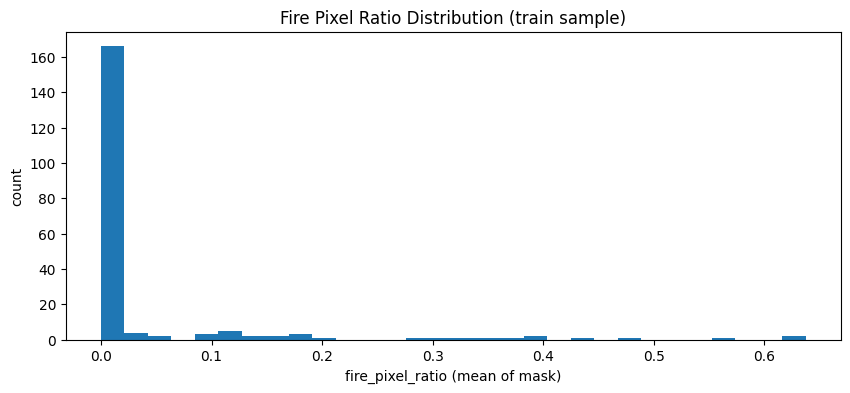

Showing example NO-FIRE patches...


In [ ]:
# ============================================================
# CELL 4 — Class Distribution + Fire Pixel Ratio Analysis
# Goal: avoid trivial model that predicts all non-fire
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_fire_ratio(y: np.ndarray) -> float:
    """y is (H,W) binary mask"""
    if y is None:
        return np.nan
    y_bin = (y > 0).astype(np.uint8)
    return float(y_bin.mean())

def scan_fire_stats(paths, max_items=None):
    ratios = []
    has_fire = []
    inspected = 0

    for i, p in enumerate(paths):
        if max_items is not None and inspected >= max_items:
            break
        x, y, a, meta = load_patch(p)
        r = compute_fire_ratio(y)
        ratios.append(r)
        has_fire.append(1 if (r > 0) else 0)
        inspected += 1

    ratios = np.array(ratios, dtype=np.float32)
    has_fire = np.array(has_fire, dtype=np.int32)

    stats = {
        "n": int(inspected),
        "patch_with_fire": int(has_fire.sum()),
        "patch_without_fire": int((1-has_fire).sum()),
        "pct_patch_with_fire": float(has_fire.mean() * 100.0),
        "mean_fire_ratio": float(np.nanmean(ratios)),
        "median_fire_ratio": float(np.nanmedian(ratios)),
        "max_fire_ratio": float(np.nanmax(ratios)),
        "min_fire_ratio": float(np.nanmin(ratios)),
    }
    return ratios, stats

# Scan small sample first (fast)
MAX_SCAN = min(300, len(train_paths))  # adjust as needed
train_ratios, train_stats = scan_fire_stats(train_paths, max_items=MAX_SCAN)

print("Train stats (sampled):")
for k, v in train_stats.items():
    print(f"  {k}: {v}")

# Plot histogram of fire ratios
plt.figure(figsize=(10,4))
plt.hist(train_ratios[~np.isnan(train_ratios)], bins=30)
plt.title("Fire Pixel Ratio Distribution (train sample)")
plt.xlabel("fire_pixel_ratio (mean of mask)")
plt.ylabel("count")
plt.show()

# Show a few examples: no-fire vs fire patches
def show_examples_by_fire(paths, want_fire=True, k=3):
    shown = 0
    for p in paths:
        x, y, a, meta = load_patch(p)
        r = compute_fire_ratio(y)
        if want_fire and r > 0:
            show_patch_views(x, y=y, a=a, band_map={}, title_prefix=f"FirePatch r={r:.4f}: ")
            shown += 1
        if (not want_fire) and r == 0:
            show_patch_views(x, y=y, a=a, band_map={}, title_prefix=f"NoFirePatch r={r:.4f}: ")
            shown += 1
        if shown >= k:
            break

print("Showing example NO-FIRE patches...")
show_examples_by_fire(train_paths, want_fire=False, k=2)

print("Showing example FIRE patches...")
show_examples_by_fire(train_paths, want_fire=True, k=2)

In [3]:
# ============================================================
# CELL 5 — PyTorch Dataset (13 channels: 12 S2 + 1 Aerosol)
# ============================================================

import numpy as np
import torch
from torch.utils.data import Dataset

class Sen2FireSegDataset(Dataset):
    """
    Loads one .npz patch containing:
      - image: (12,H,W) or (H,W,12)  int16
      - aerosol: (H,W)               float-ish
      - label: (H,W)                 0/1 (or 0..255 but effectively binary)
    Returns:
      X: torch.float32 (13,H,W)
      y: torch.float32 (1,H,W)
    """

    def __init__(self, paths, img_key="image", aer_key="aerosol", label_key="label",
                 normalize=True, mean=None, std=None, band_map=None, debug=False):
        self.paths = list(paths)
        self.img_key = img_key
        self.aer_key = aer_key
        self.label_key = label_key

        self.normalize = normalize
        self.mean = mean
        self.std = std
        self.debug = debug

        # Optional mapping for computing NDVI/NBR later (not used in this cell)
        self.band_map = band_map or {
            "B1":0, "B2":1, "B3":2, "B4":3, "B5":4, "B6":5, "B7":6,
            "B8":7, "B9":8, "B10":9, "B11":10, "B12":11
        }

        if self.normalize:
            if (self.mean is None) or (self.std is None):
                raise ValueError("normalize=True requires mean and std (per-channel).")

            self.mean = np.asarray(self.mean, dtype=np.float32)
            self.std = np.asarray(self.std, dtype=np.float32)

            if self.mean.shape[0] != 13 or self.std.shape[0] != 13:
                raise ValueError(f"mean/std must be length 13 (12 S2 + 1 aerosol). Got mean={self.mean.shape}, std={self.std.shape}")

    def __len__(self):
        return len(self.paths)

    def _load_npz(self, path):
        with np.load(path) as data:
            if self.img_key not in data:
                raise KeyError(f"'{self.img_key}' not found in {path}. keys={list(data.keys())}")
            if self.aer_key not in data:
                raise KeyError(f"'{self.aer_key}' not found in {path}. keys={list(data.keys())}")
            if self.label_key not in data:
                raise KeyError(f"'{self.label_key}' not found in {path}. keys={list(data.keys())}")

            x = data[self.img_key]       # (12,H,W) or (H,W,12)
            a = data[self.aer_key]       # (H,W)
            y = data[self.label_key]     # (H,W) or (H,W,1)
        return x, a, y

    def _to_hwc(self, x):
        # normalize shape to (H,W,C)
        if x.ndim != 3:
            raise ValueError(f"Expected 3D image array, got shape={x.shape}")

        # if CHW: (12,H,W)
        if x.shape[0] == 12 and x.shape[-1] != 12:
            x = np.transpose(x, (1, 2, 0))
        # else assume HWC already
        return x

    def __getitem__(self, idx):
        path = self.paths[idx]
        x, a, y = self._load_npz(path)

        x = self._to_hwc(x).astype(np.float32)  # (H,W,12)
        a = a.astype(np.float32)                # (H,W)
        if y.ndim == 3 and y.shape[-1] == 1:
            y = y[..., 0]
        y = (y > 0).astype(np.float32)          # (H,W) binary

        # Stack aerosol as channel-13
        a = a[..., None]                        # (H,W,1)
        x13 = np.concatenate([x, a], axis=-1)   # (H,W,13)

        # HWC -> CHW for PyTorch
        x13 = np.transpose(x13, (2, 0, 1))      # (13,H,W)
        y = y[None, ...]                        # (1,H,W)

        # Normalize per channel if enabled
        if self.normalize:
            # (13,H,W) - (13,1,1)
            x13 = (x13 - self.mean[:, None, None]) / (self.std[:, None, None] + 1e-6)

        X = torch.from_numpy(x13).float()
        Y = torch.from_numpy(y).float()

        if self.debug:
            return X, Y, path
        return X, Y

# 3. Normalize band

In [4]:
# ============================================================
# CELL 6 — Compute Mean/Std for 13 channels (12 S2 + aerosol)
# ============================================================

import numpy as np

def compute_mean_std_13(paths, max_items=200, img_key="image", aer_key="aerosol", label_key="label"):
    """
    Compute per-channel mean/std for X (13 channels) using up to max_items patches.
    Uses streaming accumulation to be memory safe.
    Returns:
      mean: (13,)
      std : (13,)
    """

    n_used = 0
    sum_c = np.zeros((13,), dtype=np.float64)
    sumsq_c = np.zeros((13,), dtype=np.float64)
    count_per_c = 0

    for i, p in enumerate(paths):
        if n_used >= max_items:
            break

        with np.load(p) as data:
            x = data[img_key]
            a = data[aer_key]

        # Ensure HWC for image
        if x.ndim != 3:
            raise ValueError(f"Expected 3D image, got {x.shape} in {p}")
        if x.shape[0] == 12 and x.shape[-1] != 12:
            x = np.transpose(x, (1, 2, 0))  # CHW->HWC
        x = x.astype(np.float32)  # (H,W,12)

        a = a.astype(np.float32)  # (H,W)
        a = a[..., None]          # (H,W,1)

        x13 = np.concatenate([x, a], axis=-1)  # (H,W,13)

        # Flatten spatial dims
        H, W, C = x13.shape
        flat = x13.reshape(-1, C)  # (H*W, 13)

        sum_c += flat.sum(axis=0)
        sumsq_c += (flat ** 2).sum(axis=0)
        count_per_c += flat.shape[0]
        n_used += 1

    mean = sum_c / (count_per_c + 1e-12)
    var = (sumsq_c / (count_per_c + 1e-12)) - (mean ** 2)
    var = np.maximum(var, 1e-12)
    std = np.sqrt(var)

    return mean.astype(np.float32), std.astype(np.float32), n_used

# Compute using your train_paths (already small-sampled and balanced at patch-level)
MEAN_13, STD_13, N_USED = compute_mean_std_13(train_paths, max_items=min(200, len(train_paths)))
print("Computed normalization stats from patches:", N_USED)
print("MEAN_13 shape:", MEAN_13.shape, "STD_13 shape:", STD_13.shape)

# Optional: print summary per channel
channel_names_13 = [
    "B1","B2","B3","B4","B5","B6","B7","B8","B9","B10","B11","B12","Aerosol"
]
for i, name in enumerate(channel_names_13):
    print(f"{i:02d} {name:>7s} | mean={MEAN_13[i]:.4f} | std={STD_13[i]:.4f}")

# Create datasets (train/val/test)
train_ds = Sen2FireSegDataset(train_paths, normalize=True, mean=MEAN_13, std=STD_13)
val_ds   = Sen2FireSegDataset(val_paths,   normalize=True, mean=MEAN_13, std=STD_13)
test_ds  = Sen2FireSegDataset(test_paths,  normalize=True, mean=MEAN_13, std=STD_13)

print("Dataset sizes:", len(train_ds), len(val_ds), len(test_ds))

# Quick shape check
X0, Y0 = train_ds[0]
print("One sample shapes => X:", tuple(X0.shape), "Y:", tuple(Y0.shape), "| dtype:", X0.dtype, Y0.dtype)

Computed normalization stats from patches: 200
MEAN_13 shape: (13,) STD_13 shape: (13,)
00      B1 | mean=894.6500 | std=618.9993
01      B2 | mean=896.9222 | std=583.1821
02      B3 | mean=957.1520 | std=512.6953
03      B4 | mean=1003.7296 | std=484.0052
04      B5 | mean=1260.7191 | std=455.1817
05      B6 | mean=1657.2307 | std=422.1155
06      B7 | mean=1844.6925 | std=446.5549
07      B8 | mean=1974.2153 | std=477.6879
08      B9 | mean=2077.8271 | std=481.3326
09     B10 | mean=2093.1082 | std=472.2231
10     B11 | mean=2371.4363 | std=999.7356
11     B12 | mean=1685.3896 | std=934.7156
12 Aerosol | mean=0.8461 | std=2.1361
Dataset sizes: 1116 247 246
One sample shapes => X: (13, 512, 512) Y: (1, 512, 512) | dtype: torch.float32 torch.float32


# 4. Imbalanced handling

## Using WeightedRandomSampler (hasil kurang bagus)

In [8]:
# ============================================================
# CELL 7 — DataLoader + WeightedRandomSampler + Batch Sanity
# Goal:
# 1) Ensure batches contain enough fire patches (patch-level imbalance handling)
# 2) Verify tensor shapes, ranges, and label presence
# ============================================================

import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# ----------------------------
# 1) Build per-sample weights for train sampling
#    Weight fire-patches higher so they appear more often in batches.
# ----------------------------

def has_fire_fast(npz_path: str, label_key="label") -> int:
    with np.load(npz_path) as data:
        y = data[label_key]
        if y.ndim == 3 and y.shape[-1] == 1:
            y = y[..., 0]
        return int((y > 0).any())

train_has_fire = [has_fire_fast(p, label_key="label") for p in train_paths]

n_pos = sum(train_has_fire)
n_neg = len(train_has_fire) - n_pos
print("Train patches:", len(train_has_fire), "| has_fire=1:", n_pos, "| has_fire=0:", n_neg)

# Weights: inverse frequency (common strategy)
# If positives are rare, each positive gets larger weight.
w_pos = 1.0 / max(n_pos, 1)
w_neg = 1.0 / max(n_neg, 1)

sample_weights = [w_pos if hf == 1 else w_neg for hf in train_has_fire]
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # one "epoch" length
    replacement=True
)

# ----------------------------
# 2) DataLoaders
# ----------------------------
BATCH_SIZE = 4
NUM_WORKERS = 2  # set 0 if Windows/local issues

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# ----------------------------
# 3) Batch sanity check
# ----------------------------
def batch_sanity_check(loader, n_batches=2):
    for bi, (X, Y) in enumerate(loader):
        print(f"\nBatch {bi} => X: {tuple(X.shape)} | Y: {tuple(Y.shape)} | dtype: {X.dtype}")
        # X should be (B, 13, 512, 512), Y should be (B, 1, 512, 512)
        print("X min/max:", float(X.min()), float(X.max()))
        print("Y unique:", torch.unique(Y))
        # How many samples in this batch contain any fire pixels?
        batch_has_fire = (Y.sum(dim=(1,2,3)) > 0).sum().item()
        print("Batch samples with fire:", batch_has_fire, "/", X.shape[0])

        if bi + 1 >= n_batches:
            break

batch_sanity_check(train_loader, n_batches=2)

Train patches: 1116 | has_fire=1: 279 | has_fire=0: 837

Batch 0 => X: (4, 13, 512, 512) | Y: (4, 1, 512, 512) | dtype: torch.float32
X min/max: -3.546699047088623 14.609374046325684
Y unique: tensor([0., 1.])
Batch samples with fire: 3 / 4

Batch 1 => X: (4, 13, 512, 512) | Y: (4, 1, 512, 512) | dtype: torch.float32
X min/max: -4.065866470336914 14.446757316589355
Y unique: tensor([0., 1.])
Batch samples with fire: 2 / 4


VAL stats (sampled):
  n: 247
  patch_with_fire: 35
  patch_without_fire: 212
  pct_patch_with_fire: 14.17004048582996
  mean_fire_ratio: 0.03506290540099144
  median_fire_ratio: 0.0
  max_fire_ratio: 0.8002471923828125
  min_fire_ratio: 0.0


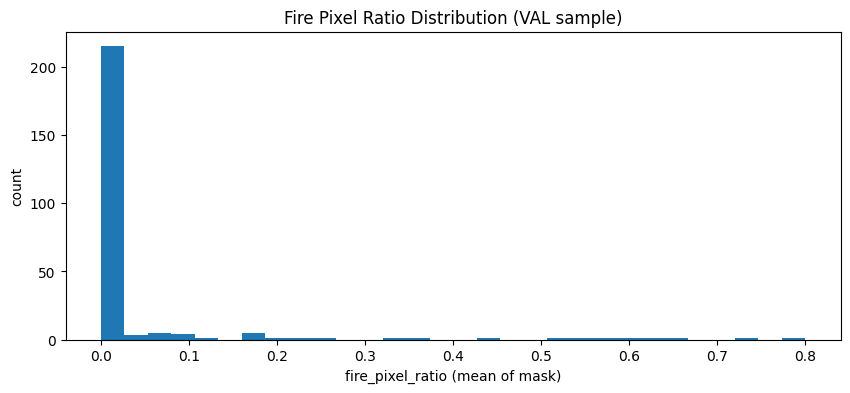


Showing 2 VAL no-fire examples...


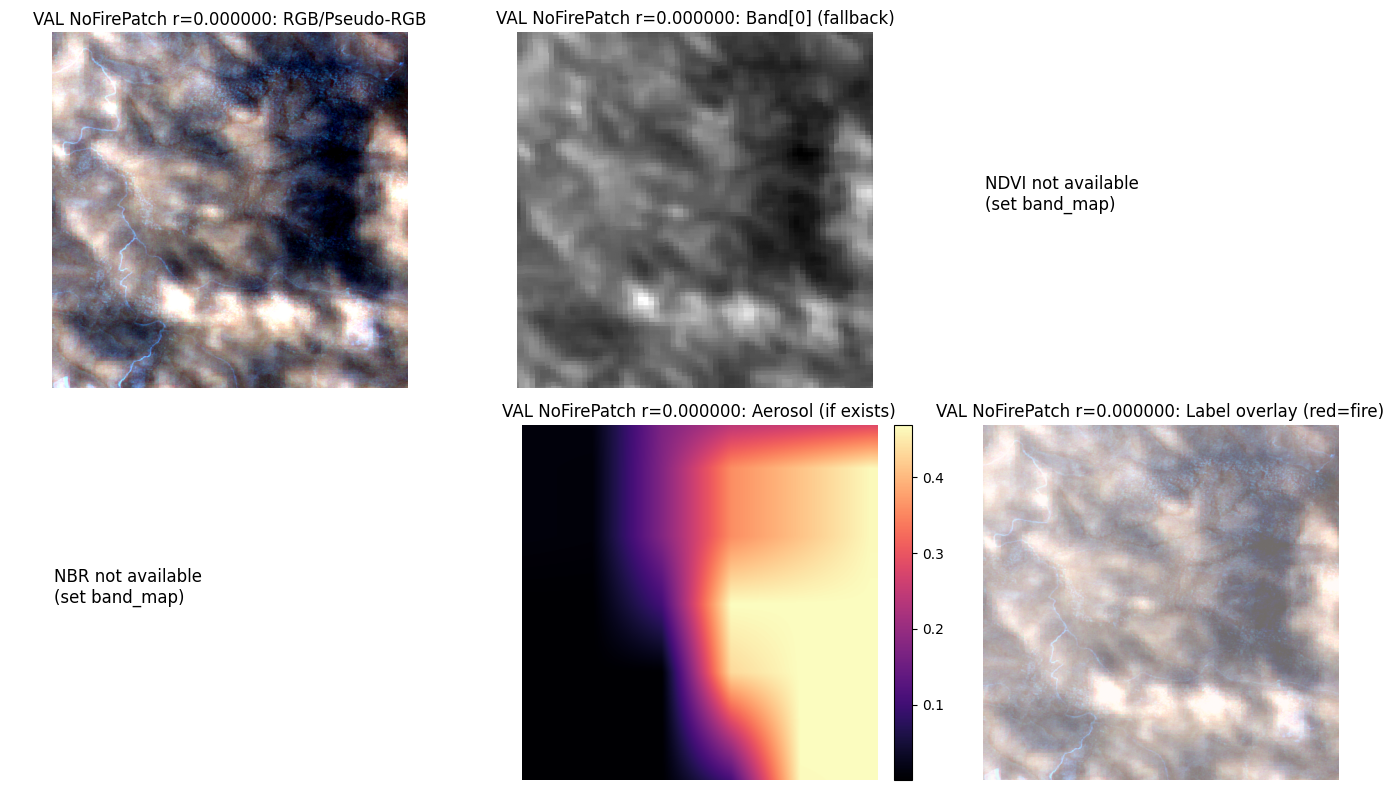

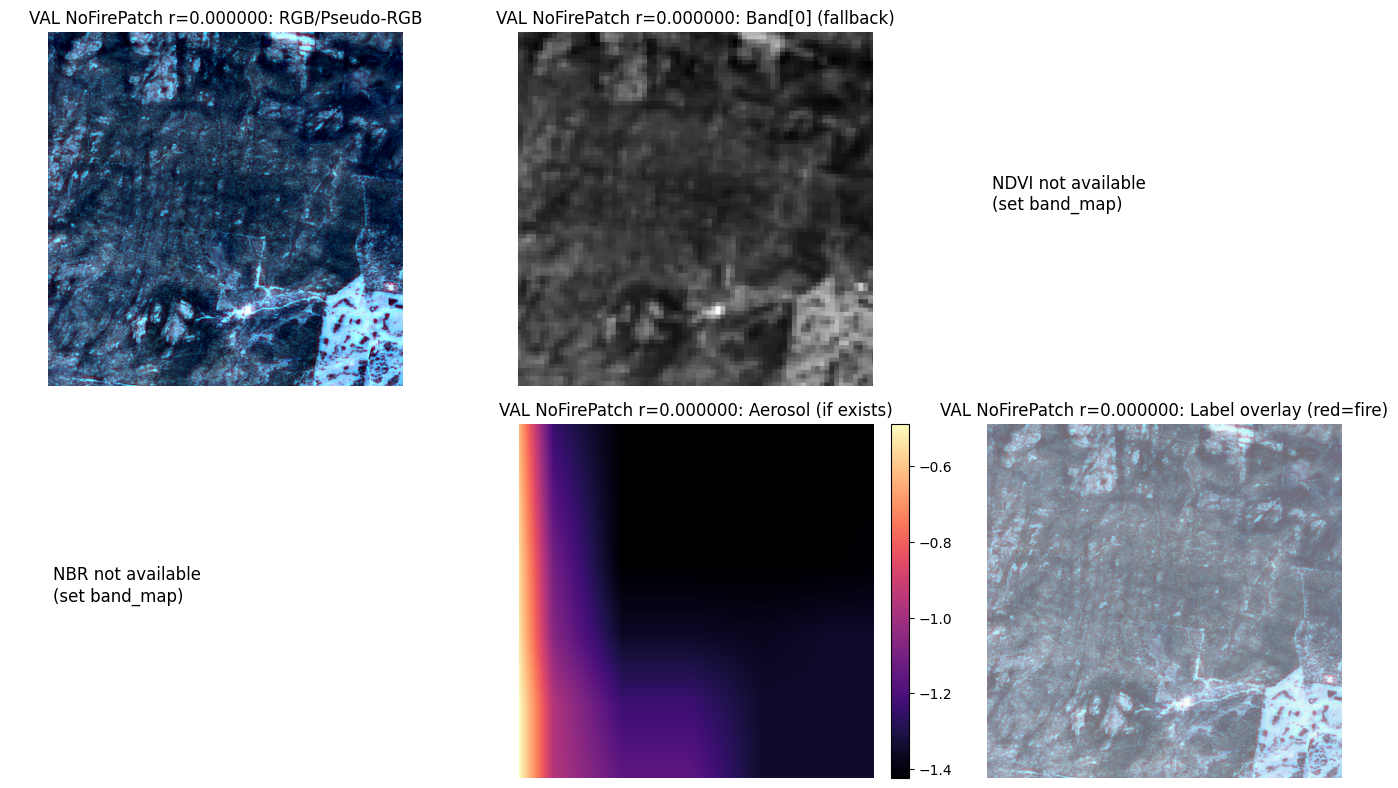

Showing 2 VAL fire examples...


In [ ]:
# ============================================================
# CELL A — VAL Fire Statistics (Patch-level & Pixel-level)
# Purpose:
# - Understand how difficult validation is (how many fire patches exist)
# - Quantify pixel imbalance in VAL
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

def compute_fire_ratio_from_mask(y: np.ndarray) -> float:
    """y: (H,W) or (1,H,W) binary/0-1 mask"""
    if y is None:
        return np.nan
    if y.ndim == 3:
        y = y[0]
    yb = (y > 0).astype(np.uint8)
    return float(yb.mean())

def scan_fire_stats_from_paths(paths, max_items=None):
    ratios = []
    has_fire = []
    inspected = 0

    for p in paths:
        if max_items is not None and inspected >= max_items:
            break
        x, y, a, meta = load_patch(p)
        r = compute_fire_ratio_from_mask(y)
        ratios.append(r)
        has_fire.append(1 if r > 0 else 0)
        inspected += 1

    ratios = np.array(ratios, dtype=np.float32)
    has_fire = np.array(has_fire, dtype=np.int32)

    stats = {
        "n": int(inspected),
        "patch_with_fire": int(has_fire.sum()),
        "patch_without_fire": int((1 - has_fire).sum()),
        "pct_patch_with_fire": float(has_fire.mean() * 100.0),
        "mean_fire_ratio": float(np.nanmean(ratios)),
        "median_fire_ratio": float(np.nanmedian(ratios)),
        "max_fire_ratio": float(np.nanmax(ratios)),
        "min_fire_ratio": float(np.nanmin(ratios)),
    }
    return ratios, has_fire, stats

MAX_VAL_SCAN = min(500, len(val_paths))  # adjust if needed
val_ratios, val_has_fire, val_stats = scan_fire_stats_from_paths(val_paths, max_items=MAX_VAL_SCAN)

print("VAL stats (sampled):")
for k, v in val_stats.items():
    print(f"  {k}: {v}")

# Histogram (log-friendly)
plt.figure(figsize=(10,4))
plt.hist(val_ratios[~np.isnan(val_ratios)], bins=30)
plt.title("Fire Pixel Ratio Distribution (VAL sample)")
plt.xlabel("fire_pixel_ratio (mean of mask)")
plt.ylabel("count")
plt.show()

# Optional: show few fire/no-fire examples (comment out if slow)
def show_examples(paths, want_fire=True, k=2):
    shown = 0
    for p in paths:
        x, y, a, meta = load_patch(p)
        r = compute_fire_ratio_from_mask(y)
        if want_fire and r > 0:
            show_patch_views(x, y=y, a=a, band_map={}, title_prefix=f"VAL FirePatch r={r:.6f}: ")
            shown += 1
        if (not want_fire) and r == 0:
            show_patch_views(x, y=y, a=a, band_map={}, title_prefix=f"VAL NoFirePatch r={r:.6f}: ")
            shown += 1
        if shown >= k:
            break

print("\nShowing 2 VAL no-fire examples...")
show_examples(val_paths, want_fire=False, k=2)

print("Showing 2 VAL fire examples...")
show_examples(val_paths, want_fire=True, k=2)

## Using BalancedBatchSampler (harusnya jadi yang ini)

In [5]:
# ============================================================
# CELL B (REPLACE) — BalancedBatchSampler (guarantee fire in each batch)
# Uses has_fire from manifest (train_df_s) to avoid rescanning npz files
#
# Why replace?
# - Faster (no re-read npz)
# - Consistent with your split logic (Cell 2)
# - Guarantees stable positive presence per batch
#
# Output:
# - train_loader (redefined)
# - quick batch sanity check
# ============================================================

import random
from torch.utils.data import Sampler, DataLoader

# 0) Sanity: ensure train_df_s exists and aligned with train_paths
assert "train_df_s" in globals(), "train_df_s not found. Run CELL 2 first."
assert len(train_df_s) == len(train_paths), "Mismatch: train_df_s length != train_paths length."

# 1) Build indices from has_fire column (NO npz scanning needed)
train_fire_idx   = train_df_s.index[train_df_s["has_fire"] == 1].tolist()
train_nofire_idx = train_df_s.index[train_df_s["has_fire"] == 0].tolist()

print("Train fire patches:", len(train_fire_idx))
print("Train no-fire patches:", len(train_nofire_idx))
print("Train total:", len(train_df_s))

if len(train_fire_idx) == 0:
    raise RuntimeError("No fire patches in training set. Check Cell 2 logic / FIRE_PATCH_MIN_RATIO.")
if len(train_nofire_idx) == 0:
    raise RuntimeError("No non-fire patches in training set. Unexpected for Sen2Fire.")

# 2) Balanced sampler
class BalancedBatchSampler(Sampler):
    """
    Yield indices so each batch contains:
      k_fire fire patches + k_nofire non-fire patches.
    This fixes the main issue: some batches had 0 fire.
    """
    def __init__(self, fire_idx, nofire_idx, batch_size=4, fire_frac=0.5, seed=42, drop_last=True):
        assert batch_size >= 2, "batch_size should be >= 2"
        self.fire_idx = list(fire_idx)
        self.nofire_idx = list(nofire_idx)
        self.batch_size = batch_size
        self.k_fire = max(1, int(round(batch_size * fire_frac)))
        self.k_nofire = batch_size - self.k_fire
        self.seed = seed
        self.drop_last = drop_last

        if self.k_nofire <= 0:
            raise ValueError("fire_frac too high for given batch_size; k_nofire=0")

    def __iter__(self):
        rng = random.Random(self.seed)
        fire = self.fire_idx.copy()
        nofire = self.nofire_idx.copy()

        rng.shuffle(fire)
        rng.shuffle(nofire)

        i_f, i_n = 0, 0
        while (i_f + self.k_fire <= len(fire)) and (i_n + self.k_nofire <= len(nofire)):
            batch = fire[i_f:i_f+self.k_fire] + nofire[i_n:i_n+self.k_nofire]
            rng.shuffle(batch)
            for idx in batch:
                yield idx
            i_f += self.k_fire
            i_n += self.k_nofire

        # drop_last=True => ignore leftover to keep ratio stable

    def __len__(self):
        n_batches = min(len(self.fire_idx)//self.k_fire, len(self.nofire_idx)//self.k_nofire)
        return n_batches * self.batch_size

# 3) Choose sampler parameters
# Recommended for your case:
# - train has 25% fire patches (already helped), so we do NOT need 50% fire every batch.
# - Use fire_frac 0.33 (≈ 1 fire in batch of 4) to reduce over-predicting fire.
BATCH_SIZE = 4
FIRE_FRAC  = 0.25  # 0.25 => 1 fire per batch (since round(4*0.25)=1)
SEED_LOCAL = SEED

sampler = BalancedBatchSampler(
    fire_idx=train_fire_idx,
    nofire_idx=train_nofire_idx,
    batch_size=BATCH_SIZE,
    fire_frac=FIRE_FRAC,
    seed=SEED_LOCAL,
    drop_last=True
)

# 4) Rebuild train_loader
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0,
    pin_memory=True
)

BATCH_SIZE = 4
NUM_WORKERS = 2 

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("\n✅ train_loader rebuilt with BalancedBatchSampler")
print("Batch size:", BATCH_SIZE, "| fire_frac:", FIRE_FRAC, "(≈ fire per batch =", max(1, int(round(BATCH_SIZE*FIRE_FRAC))), ")")

# 5) Batch sanity check (important for lecturer)
def batch_sanity_check(loader, n_batches=3):
    it = iter(loader)
    for b in range(n_batches):
        X, Y = next(it)
        fire_in_batch = int((Y.sum(dim=(1,2,3)) > 0).sum().item())
        print(f"Batch {b}: X={tuple(X.shape)} Y={tuple(Y.shape)} | samples_with_fire={fire_in_batch}/{X.shape[0]} | total_fire_pixels={float(Y.sum().item()):.0f}")

batch_sanity_check(train_loader, n_batches=3)

Train fire patches: 279
Train no-fire patches: 837
Train total: 1116

✅ train_loader rebuilt with BalancedBatchSampler
Batch size: 4 | fire_frac: 0.25 (≈ fire per batch = 1 )
Batch 0: X=(4, 13, 512, 512) Y=(4, 1, 512, 512) | samples_with_fire=1/4 | total_fire_pixels=34595
Batch 1: X=(4, 13, 512, 512) Y=(4, 1, 512, 512) | samples_with_fire=1/4 | total_fire_pixels=27201
Batch 2: X=(4, 13, 512, 512) Y=(4, 1, 512, 512) | samples_with_fire=1/4 | total_fire_pixels=29997


# 5. Baseline Model (U-Net)

In [6]:
# ============================================================
# CELL 8 — Model + Loss + Metrics
# Goal:
# - Use a simple, stable baseline U-Net for 13-channel segmentation
# - Handle pixel-level imbalance via BCEWithLogits + Soft Dice
# - Provide metrics: precision/recall/F1/IoU for fire class
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------
# 1) Simple U-Net (lightweight baseline)
# ----------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self, in_channels=13, out_channels=1, base=32):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base*4, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = DoubleConv(base*2, base)

        self.out = nn.Conv2d(base, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        b = self.bottleneck(self.pool3(e3))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        logits = self.out(d1)
        return logits

model = UNetSmall(in_channels=13, out_channels=1, base=32).to(DEVICE)
print(model.__class__.__name__, "ready on", DEVICE)

# ----------------------------
# 2) Loss: BCEWithLogits + Soft Dice
# ----------------------------
def soft_dice_loss(logits, targets, eps=1e-6):
    """
    logits: (B,1,H,W)
    targets: (B,1,H,W) in {0,1}
    """
    probs = torch.sigmoid(logits)
    num = 2.0 * (probs * targets).sum(dim=(2,3))
    den = (probs + targets).sum(dim=(2,3)) + eps
    dice = num / den
    return 1.0 - dice.mean()

# pos_weight for BCE helps pixel imbalance:
# approximate from one batch or from dataset later; start simple with pos_weight=5~20
POS_WEIGHT = 10.0
bce_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([POS_WEIGHT], device=DEVICE))

def combined_loss(logits, targets, alpha=0.5):
    """
    alpha: weight between BCE and Dice
    """
    bce = bce_loss_fn(logits, targets)
    dice = soft_dice_loss(logits, targets)
    return alpha*bce + (1-alpha)*dice, bce.detach(), dice.detach()

# ----------------------------
# 3) Metrics: Precision/Recall/F1/IoU for fire class
# ----------------------------
@torch.no_grad()
def compute_metrics_from_logits(logits, targets, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs >= thr).float()

    tp = (preds * targets).sum(dim=(1,2,3))
    fp = (preds * (1 - targets)).sum(dim=(1,2,3))
    fn = ((1 - preds) * targets).sum(dim=(1,2,3))

    precision = (tp / (tp + fp + eps)).mean().item()
    recall    = (tp / (tp + fn + eps)).mean().item()
    f1        = (2*tp / (2*tp + fp + fn + eps)).mean().item()

    # IoU = TP / (TP + FP + FN)
    iou = (tp / (tp + fp + fn + eps)).mean().item()

    return {"precision": precision, "recall": recall, "f1": f1, "iou": iou}

UNetSmall ready on cuda


# 6. Overfit Sanity Check

In [21]:
# ============================================================
# FIX — Overfit Sanity Check must use a FIXED BATCH with fire pixels
# Strategy:
# 1) Build a small dataset of ONLY fire patches (has_fire=1)
# 2) Take one fixed batch from it (guaranteed Y has positives)
# 3) Repeat training on that batch
# ============================================================

import numpy as np
import torch
from torch.utils.data import Subset, DataLoader

# 1) Collect indices that truly have fire pixels (has_fire=1)
fire_indices = [i for i, hf in enumerate(train_has_fire) if hf == 1]
print("Total fire patches available:", len(fire_indices))

if len(fire_indices) < 2:
    raise RuntimeError("Not enough fire patches to run fire-only overfit sanity. Increase training sample or rescan train_has_fire.")

# 2) Build fire-only subset (take e.g. first 16 fire patches)
k_fire_only = min(16, len(fire_indices))
fire_only_subset = Subset(train_ds, fire_indices[:k_fire_only])

fire_only_loader = DataLoader(fire_only_subset, batch_size=2, shuffle=True, num_workers=0)

# 3) Grab one FIXED batch that is guaranteed to contain fire pixels
X_fix, Y_fix = next(iter(fire_only_loader))
X_fix, Y_fix = X_fix.to(DEVICE), Y_fix.to(DEVICE)

print("Fixed fire batch shapes:", tuple(X_fix.shape), tuple(Y_fix.shape))
print("Fixed fire batch total fire pixels:", float(Y_fix.sum().item()))
print("Fixed fire batch samples with fire:", int((Y_fix.sum(dim=(1,2,3)) > 0).sum().item()), "/", X_fix.shape[0])

if Y_fix.sum().item() == 0:
    raise RuntimeError("Unexpected: picked a fire-only batch but got zero fire pixels. Check label loading/binarization.")

# 4) More stable loss for sanity check: reduce POS_WEIGHT
POS_WEIGHT = 3.0
bce_loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([POS_WEIGHT], device=DEVICE))

def soft_dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2.0 * (probs * targets).sum(dim=(2,3))
    den = (probs + targets).sum(dim=(2,3)) + eps
    dice = num / den
    return 1.0 - dice.mean()

def combined_loss_local(logits, targets, alpha=0.5):
    bce = bce_loss_fn(logits, targets)
    dice = soft_dice_loss(logits, targets)
    return alpha*bce + (1-alpha)*dice, bce.detach(), dice.detach()

@torch.no_grad()
def eval_thresholds(logits, targets, thrs=(0.1,0.2,0.3,0.4,0.5)):
    print("Threshold sweep:")
    for t in thrs:
        mets = compute_metrics_from_logits(logits, targets, thr=t)
        print(f"  thr={t:.1f} -> F1={mets['f1']:.4f} IoU={mets['iou']:.4f} P={mets['precision']:.4f} R={mets['recall']:.4f}")

# 5) Fixed-batch overfit loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_fixed_fire_overfit(model, X, Y, steps=200, thr_main=0.5, alpha=0.5):
    model.train()
    for step in range(steps):
        optimizer.zero_grad()
        logits = model(X)
        loss, bce_part, dice_part = combined_loss_local(logits, Y, alpha=alpha)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            mets = compute_metrics_from_logits(logits.detach(), Y, thr=thr_main)
            probs = torch.sigmoid(logits.detach())
            pred_pos = float((probs >= thr_main).float().sum().item())
            true_pos = float(Y.sum().item())

            print(f"\nStep {step:03d}")
            print(f"  loss={loss.item():.4f} | bce={bce_part.item():.4f} | dice_loss={dice_part.item():.4f}")
            print(f"  @thr={thr_main:.2f} -> F1={mets['f1']:.4f} IoU={mets['iou']:.4f} P={mets['precision']:.4f} R={mets['recall']:.4f}")
            print(f"  pred_pos_pixels={pred_pos:.0f} | true_pos_pixels={true_pos:.0f}")

            eval_thresholds(logits.detach(), Y, thrs=(0.1,0.2,0.3,0.4,0.5))

run_fixed_fire_overfit(model, X_fix, Y_fix, steps=150, thr_main=0.5, alpha=0.5)

Total fire patches available: 40
Fixed fire batch shapes: (2, 13, 512, 512) (2, 1, 512, 512)
Fixed fire batch total fire pixels: 201902.0
Fixed fire batch samples with fire: 2 / 2

Step 000
  loss=1.7098 | bce=2.6140 | dice_loss=0.8056
  @thr=0.50 -> F1=0.0000 IoU=0.0000 P=0.0000 R=0.0000
  pred_pos_pixels=0 | true_pos_pixels=201902
Threshold sweep:
  thr=0.1 -> F1=0.4736 IoU=0.3430 P=0.3801 R=0.8967
  thr=0.2 -> F1=0.2110 IoU=0.1184 P=0.5791 R=0.1294
  thr=0.3 -> F1=0.0419 IoU=0.0217 P=0.6787 R=0.0223
  thr=0.4 -> F1=0.0034 IoU=0.0017 P=0.7411 R=0.0017
  thr=0.5 -> F1=0.0000 IoU=0.0000 P=0.0000 R=0.0000

Step 020
  loss=0.6143 | bce=0.7884 | dice_loss=0.4402
  @thr=0.50 -> F1=0.6780 IoU=0.5213 P=0.5705 R=0.8389
  pred_pos_pixels=309762 | true_pos_pixels=201902
Threshold sweep:
  thr=0.1 -> F1=0.6204 IoU=0.4684 P=0.4689 R=0.9954
  thr=0.2 -> F1=0.6472 IoU=0.4920 P=0.4933 R=0.9896
  thr=0.3 -> F1=0.6766 IoU=0.5199 P=0.5251 R=0.9711
  thr=0.4 -> F1=0.6877 IoU=0.5310 P=0.5497 R=0.9207
  t

# 7. Training model

In [9]:
# ============================================================
# CELL — Threshold Sweep on VAL (pick best thr for F1)
# ============================================================

thr_list = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
            0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

rows = []
for t in thr_list:
    va = evaluate_global(model, val_loader, thr=t, alpha=0.5)
    rows.append({"thr": t, "precision": va["precision"], "recall": va["recall"],
                 "f1": va["f1"], "iou": va["iou"], "TP": va["TP"], "FP": va["FP"], "FN": va["FN"]})

df_thr = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)
display(df_thr)

best_thr = float(df_thr.iloc[0]["thr"])
print("✅ Best threshold by VAL F1:", best_thr)

thr  precision    recall        f1       iou         TP          FP  \
0   0.75   0.401365  0.254125  0.311208  0.184279   576942.0    860507.0   
1   0.80   0.517580  0.202948  0.291569  0.170665   460754.0    429455.0   
2   0.70   0.262900  0.322484  0.289660  0.169358   732139.0   2052714.0   
3   0.85   0.605836  0.156613  0.248886  0.142130   355559.0    231331.0   
4   0.65   0.177202  0.384918  0.242682  0.138098   873882.0   4057672.0   
5   0.60   0.129018  0.452357  0.200773  0.111588  1026989.0   6933064.0   
6   0.90   0.612769  0.118194  0.198165  0.109980   268337.0    169572.0   
7   0.55   0.110015  0.540330  0.182808  0.100599  1226715.0   9923750.0   
8   0.50   0.100174  0.598747  0.171633  0.093872  1359341.0  12210430.0   
9   0.45   0.092146  0.644894  0.161251  0.087696  1464109.0  14424985.0   
10  0.40   0.082215  0.703366  0.147222  0.079460  1596857.0  17826003.0   
11  0.35   0.069731  0.753712  0.127652  0.068178  1711159.0  22828254.0   
12  0.30   0.062202  0.795285  0.115379  0.061221  1805541.0  27221721.0   
13  0.25   0.056680  0.827883  0.106097  0.056020  1879550.0  31280966.0   
14  0.20   0.051466  0.854374  0.097084  0.051018  1939691.0  35749188.0   
15  0.15   0.046872  0.884340  0.089026  0.046587  2007725.0  40826219.0   
16  0.10   0.043007  0.939580  0.082250  0.042889  2133136.0  47466095.0   
17  0.05   0.035063  1.000000  0.067750  0.035063  2270308.0  62479147.0   

           FN  
0   1693366.0  
1   1809554.0  
2   1538169.0  
3   1914749.0  
4   1396426.0  
5   1243319.0  
6   2001971.0  
7   1043593.0  
8    910967.0  
9    806199.0  
10   673451.0  
11   559149.0  
12   464767.0  
13   390758.0  
14   330617.0  
15   262583.0  
16   137172.0  
17        0.0

✅ Best threshold by VAL F1: 0.75


In [12]:
# ============================================================
# CELL — Data-driven POS_WEIGHT from TRAIN pixels (fast scan)
# ============================================================

# ---------- Helper: find likely keys ----------
def pick_key(npz_obj, candidates):
    keys = list(npz_obj.keys())
    for c in candidates:
        if c in keys:
            return c
    return None


# ---------- Helper: load one patch ----------
def load_patch(npz_path: str):
    """
    Returns:
      x: np.ndarray (H, W, C)  multispectral or composite
      y: np.ndarray (H, W)     binary mask (0/1) if exists, else None
      a: np.ndarray (H, W)     aerosol if exists, else None
      meta: dict              debugging info
    """
    with np.load(npz_path) as data:
        # Common naming guesses (you may need to adjust)
        x_key = pick_key(data, ["x", "image", "img", "s2", "sentinel2", "patch"])
        y_key = pick_key(data, ["y", "mask", "label", "labels", "gt"])
        a_key = pick_key(data, ["aerosol", "s5p", "ai", "a"])

        if x_key is None:
            raise KeyError(f"Cannot find image key in npz. Available keys: {list(data.keys())}")

        x = data[x_key]
        y = data[y_key] if y_key is not None else None
        a = data[a_key] if a_key is not None else None

        meta = {
            "x_key": x_key, "y_key": y_key, "a_key": a_key,
            "x_shape": x.shape, "x_dtype": str(x.dtype),
            "y_shape": None if y is None else y.shape,
            "a_shape": None if a is None else a.shape,
            "keys": list(data.keys())
        }

    # Normalize shape to (H, W, C)
    # Some datasets store (C, H, W)
    if x.ndim == 3 and x.shape[0] in [10, 11, 12, 13] and x.shape[0] < x.shape[-1]:
        # likely CHW -> HWC
        x = np.transpose(x, (1, 2, 0))
        meta["x_transposed_CHW_to_HWC"] = True
    else:
        meta["x_transposed_CHW_to_HWC"] = False

    # Ensure y is (H, W)
    if y is not None and y.ndim == 3:
        # sometimes stored as (H, W, 1)
        if y.shape[-1] == 1:
            y = y[..., 0]
        else:
            # fallback: take first channel
            y = y[..., 0]

    # Ensure aerosol is (H, W)
    if a is not None and a.ndim == 3:
        if a.shape[-1] == 1:
            a = a[..., 0]
        else:
            a = a[..., 0]

    return x, y, a, meta


def estimate_pos_weight_from_paths(paths, max_items=300):
    neg = 0
    pos = 0
    n = 0
    for p in paths[:max_items]:
        x, y, a, meta = load_patch(p)
        if y.ndim == 3:
            y = y[0]
        yb = (y > 0).astype(np.uint8)
        pos += int(yb.sum())
        neg += int((1 - yb).sum())
        n += 1
    # pos_weight = neg/pos
    eps = 1
    pw = neg / max(pos, eps)
    return pw, pos, neg, n

pw, pos_pix, neg_pix, n_used = estimate_pos_weight_from_paths(train_paths, max_items=min(400, len(train_paths)))
print(f"Estimated from {n_used} patches:")
print("  pos_pixels:", pos_pix)
print("  neg_pixels:", neg_pix)
print("  raw pos_weight (neg/pos):", pw)

# cap to avoid instability (common)
POS_WEIGHT = float(min(pw, 20.0))
print("  POS_WEIGHT (capped):", POS_WEIGHT)

Estimated from 400 patches:
  pos_pixels: 6656095
  neg_pixels: 98201505
  raw pos_weight (neg/pos): 14.75362130498438
  POS_WEIGHT (capped): 14.75362130498438


In [13]:
# ============================================================
# CELL 9.6 — Final Loss (Data-driven BCE pos_weight + Soft Dice)
# Place this cell:
#   AFTER model init (Cell 8)
#   AFTER POS_WEIGHT computed (Cell pos_weight)
#   BEFORE training loop (Cell 10)
# ============================================================

import torch
import torch.nn as nn

# --- Safety check
assert "POS_WEIGHT" in globals(), "POS_WEIGHT not found. Run the POS_WEIGHT estimation cell first."
print("Using POS_WEIGHT:", POS_WEIGHT)

# 1) BCE with logits + pos_weight (pixel-level imbalance handling)
bce_loss_fn = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([POS_WEIGHT], device=DEVICE, dtype=torch.float32)
)

# 2) Soft Dice Loss (computed on probabilities)
def soft_dice_loss_from_logits(logits, targets, eps=1e-7):
    """
    logits: (B,1,H,W) raw output
    targets: (B,1,H,W) in {0,1}
    returns: scalar dice loss
    """
    probs = torch.sigmoid(logits)

    # Flatten per batch
    probs = probs.view(probs.size(0), -1)
    targets = targets.view(targets.size(0), -1)

    intersection = (probs * targets).sum(dim=1)
    denom = probs.sum(dim=1) + targets.sum(dim=1)

    dice = (2.0 * intersection + eps) / (denom + eps)
    return 1.0 - dice.mean()

# 3) Combined loss
def combined_loss(logits, targets, alpha=0.6):
    """
    alpha: weight for BCE (0..1)
    recommended:
      - start alpha=0.6 (BCE slightly stronger because imbalance is extreme)
      - can tune to 0.5 later
    """
    bce = bce_loss_fn(logits, targets)
    dice = soft_dice_loss_from_logits(logits, targets)
    total = alpha * bce + (1.0 - alpha) * dice
    return total, bce.detach(), dice.detach()

print("✅ combined_loss is ready (BCE pos_weight + Dice)")

Using POS_WEIGHT: 14.75362130498438
✅ combined_loss is ready (BCE pos_weight + Dice)


In [15]:
# ============================================================
# CELL 10 (REPLACE) — Baseline Training Loop (after BalancedBatchSampler)
# Key fixes:
# 1) Evaluate with GLOBAL TP/FP/FN (stable, not misleading)
# 2) Save best checkpoint by val F1
# 3) Print TP/FP/FN to diagnose why precision/recall are low
# ============================================================

import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

EPOCHS = 20
LR = 1e-3
THR = 0.75

# --- Safety checks
assert "train_loader" in globals(), "train_loader not found. Run Cell B first."
assert "val_loader" in globals(), "val_loader not found. Build val_loader first."
assert "model" in globals(), "model not found."
assert "combined_loss" in globals(), "combined_loss not found."

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Optional: scheduler (helps if stuck)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)

def train_one_epoch(model, loader, alpha=0.5):
    model.train()
    total_loss, total_bce, total_dice = 0.0, 0.0, 0.0
    n = 0

    for X, Y in tqdm(loader, desc="train", leave=False):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(X)

        loss, bce_part, dice_part = combined_loss(logits, Y, alpha=alpha)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item())
        total_bce  += float(bce_part.item())
        total_dice += float(dice_part.item())
        n += 1

    n = max(n, 1)
    return {
        "loss": total_loss / n,
        "bce": total_bce / n,
        "dice_loss": total_dice / n
    }

@torch.no_grad()
def evaluate_global(model, loader, thr=0.5, alpha=0.5):
    """
    GLOBAL pixel-wise metrics for fire class:
    precision, recall, F1, IoU computed from aggregated TP/FP/FN
    Also returns val_loss averaged across batches.
    """
    model.eval()

    TP = 0.0
    FP = 0.0
    FN = 0.0

    total_loss = 0.0
    n_batches = 0

    for X, Y in tqdm(loader, desc="eval", leave=False):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        logits = model(X)
        probs = torch.sigmoid(logits)
        preds = (probs >= thr).float()

        TP += float((preds * Y).sum().item())
        FP += float((preds * (1 - Y)).sum().item())
        FN += float(((1 - preds) * Y).sum().item())

        loss, _, _ = combined_loss(logits, Y, alpha=alpha)
        total_loss += float(loss.item())
        n_batches += 1

    eps = 1e-8
    precision = TP / (TP + FP + eps)
    recall    = TP / (TP + FN + eps)
    f1        = (2 * TP) / (2 * TP + FP + FN + eps)
    iou       = TP / (TP + FP + FN + eps)

    return {
        "val_loss": total_loss / max(n_batches, 1),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "iou": iou,
        "TP": TP, "FP": FP, "FN": FN
    }

best_f1 = -1.0
best_epoch = -1

CKPT_DIR = "./checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
best_path = os.path.join(CKPT_DIR, "unet13_best.pth")

history = []

for epoch in range(1, EPOCHS + 1):
    tr = train_one_epoch(model, train_loader, alpha=0.5)
    va = evaluate_global(model, val_loader, thr=THR, alpha=0.5)

    scheduler.step(va["f1"])

    row = {"epoch": epoch, **tr, **va, "lr": optimizer.param_groups[0]["lr"]}
    history.append(row)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"  Train: loss={tr['loss']:.4f} | bce={tr['bce']:.4f} | dice_loss={tr['dice_loss']:.4f}")
    print(f"  Val  : val_loss={va['val_loss']:.4f} | P={va['precision']:.4f} R={va['recall']:.4f} F1={va['f1']:.4f} IoU={va['iou']:.4f}")
    print(f"        TP={va['TP']:.0f} FP={va['FP']:.0f} FN={va['FN']:.0f} | lr={optimizer.param_groups[0]['lr']:.2e}")

    if va["f1"] > best_f1:
        best_f1 = va["f1"]
        best_epoch = epoch
        torch.save({
            "model_state": model.state_dict(),
            "mean_13": MEAN_13,
            "std_13": STD_13,
            "thr": THR,
            "pos_weight": POS_WEIGHT if "POS_WEIGHT" in globals() else None,
            "epoch": epoch,
            "val_f1": best_f1,
        }, best_path)
        print("  ✅ Saved best checkpoint:", best_path)

history_df = pd.DataFrame(history)
display(history_df)

print("\nBest model:")
print("  best_epoch:", best_epoch)
print("  best_val_f1:", best_f1)
print("  checkpoint:", best_path)


Epoch 1/20
  Train: loss=0.9542 | bce=0.9845 | dice_loss=0.9240
  Val  : val_loss=0.8932 | P=0.1399 R=0.4348 F1=0.2117 IoU=0.1184
        TP=987172 FP=6070713 FN=1283136 | lr=1.00e-03
  ✅ Saved best checkpoint: ./checkpoints/unet13_best.pth



Epoch 2/20
  Train: loss=0.9396 | bce=0.9565 | dice_loss=0.9227
  Val  : val_loss=0.8648 | P=0.2337 R=0.3663 F1=0.2853 IoU=0.1664
        TP=831528 FP=2726865 FN=1438780 | lr=1.00e-03
  ✅ Saved best checkpoint: ./checkpoints/unet13_best.pth



Epoch 3/20
  Train: loss=0.9268 | bce=0.9319 | dice_loss=0.9217
  Val  : val_loss=0.8822 | P=0.2451 R=0.3441 F1=0.2863 IoU=0.1671
        TP=781308 FP=2406321 FN=1489000 | lr=1.00e-03
  ✅ Saved best checkpoint: ./checkpoints/unet13_best.pth



Epoch 4/20
  Train: loss=0.9254 | bce=0.9293 | dice_loss=0.9215
  Val  : val_loss=0.9133 | P=0.2707 R=0.3341 F1=0.2991 IoU=0.1758
        TP=758535 FP=2043513 FN=1511773 | lr=1.00e-03
  ✅ Saved best checkpoint: ./checkpoints/unet13_best.pth



Epoch 5/20
  Train: loss=0.9211 | bce=0.9208 | dice_loss=0.9214
  Val  : val_loss=0.8681 | P=0.1603 R=0.3961 F1=0.2282 IoU=0.1288
        TP=899172 FP=4710826 FN=1371136 | lr=1.00e-03



Epoch 6/20
  Train: loss=0.9083 | bce=0.8962 | dice_loss=0.9203
  Val  : val_loss=0.8404 | P=0.2707 R=0.3441 F1=0.3030 IoU=0.1786
        TP=781120 FP=2104264 FN=1489188 | lr=1.00e-03
  ✅ Saved best checkpoint: ./checkpoints/unet13_best.pth



Epoch 7/20
  Train: loss=0.9011 | bce=0.8828 | dice_loss=0.9195
  Val  : val_loss=0.8993 | P=0.2397 R=0.3758 F1=0.2927 IoU=0.1714
        TP=853114 FP=2705948 FN=1417194 | lr=1.00e-03



Epoch 8/20
  Train: loss=0.9006 | bce=0.8814 | dice_loss=0.9198
  Val  : val_loss=0.8860 | P=0.1329 R=0.5608 F1=0.2149 IoU=0.1204
        TP=1273191 FP=8306026 FN=997117 | lr=1.00e-03



Epoch 9/20
  Train: loss=0.8881 | bce=0.8572 | dice_loss=0.9190
  Val  : val_loss=0.8806 | P=0.1271 R=0.6317 F1=0.2117 IoU=0.1184
        TP=1434113 FP=9845700 FN=836195 | lr=5.00e-04



Epoch 10/20
  Train: loss=0.8731 | bce=0.8284 | dice_loss=0.9178
  Val  : val_loss=0.8500 | P=0.2147 R=0.4443 F1=0.2895 IoU=0.1693
        TP=1008747 FP=3688758 FN=1261561 | lr=5.00e-04



Epoch 11/20
  Train: loss=0.8590 | bce=0.8011 | dice_loss=0.9169
  Val  : val_loss=0.8501 | P=0.1983 R=0.4650 F1=0.2781 IoU=0.1615
        TP=1055790 FP=4267161 FN=1214518 | lr=5.00e-04



Epoch 12/20
  Train: loss=0.8494 | bce=0.7827 | dice_loss=0.9162
  Val  : val_loss=0.8580 | P=0.1747 R=0.4861 F1=0.2571 IoU=0.1475
        TP=1103641 FP=5212839 FN=1166667 | lr=2.50e-04



Epoch 13/20
  Train: loss=0.8316 | bce=0.7480 | dice_loss=0.9152
  Val  : val_loss=0.8180 | P=0.2596 R=0.4000 F1=0.3149 IoU=0.1868
        TP=908087 FP=2589823 FN=1362221 | lr=2.50e-04
  ✅ Saved best checkpoint: ./checkpoints/unet13_best.pth



Epoch 14/20
  Train: loss=0.8225 | bce=0.7304 | dice_loss=0.9145
  Val  : val_loss=0.8216 | P=0.2254 R=0.4139 F1=0.2919 IoU=0.1709
        TP=939733 FP=3228532 FN=1330575 | lr=2.50e-04



Epoch 15/20
  Train: loss=0.8166 | bce=0.7191 | dice_loss=0.9140
  Val  : val_loss=0.8238 | P=0.2165 R=0.4171 F1=0.2850 IoU=0.1662
        TP=946877 FP=3426801 FN=1323431 | lr=2.50e-04



Epoch 16/20
  Train: loss=0.8114 | bce=0.7092 | dice_loss=0.9137
  Val  : val_loss=0.8253 | P=0.2119 R=0.4211 F1=0.2819 IoU=0.1641
        TP=956051 FP=3556581 FN=1314257 | lr=1.25e-04



Epoch 17/20
  Train: loss=0.7993 | bce=0.6858 | dice_loss=0.9128
  Val  : val_loss=0.8199 | P=0.2038 R=0.3466 F1=0.2567 IoU=0.1472
        TP=786952 FP=3074118 FN=1483356 | lr=1.25e-04



Epoch 18/20
  Train: loss=0.7937 | bce=0.6749 | dice_loss=0.9124
  Val  : val_loss=0.8197 | P=0.2071 R=0.3502 F1=0.2603 IoU=0.1496
        TP=795057 FP=3044534 FN=1475251 | lr=1.25e-04



Epoch 19/20
  Train: loss=0.7891 | bce=0.6662 | dice_loss=0.9121
  Val  : val_loss=0.8188 | P=0.2136 R=0.3509 F1=0.2655 IoU=0.1531
        TP=796559 FP=2933040 FN=1473749 | lr=6.25e-05



Epoch 20/20
  Train: loss=0.7811 | bce=0.6507 | dice_loss=0.9115
  Val  : val_loss=0.8171 | P=0.2078 R=0.3291 F1=0.2547 IoU=0.1460
        TP=747088 FP=2847983 FN=1523220 | lr=6.25e-05


epoch      loss       bce  dice_loss  val_loss  precision    recall  \
0       1  0.954245  0.984511   0.923979  0.893173   0.139868  0.434819   
1       2  0.939613  0.956545   0.922681  0.864800   0.233681  0.366262   
2       3  0.926815  0.931944   0.921687  0.882180   0.245106  0.344142   
3       4  0.925419  0.929340   0.921499  0.913290   0.270707  0.334111   
4       5  0.921105  0.920784   0.921426  0.868105   0.160280  0.396057   
5       6  0.908268  0.896225   0.920312  0.840352   0.270716  0.344059   
6       7  0.901149  0.882771   0.919526  0.899295   0.239702  0.375770   
7       8  0.900604  0.881407   0.919801  0.885987   0.132912  0.560801   
8       9  0.888099  0.857226   0.918972  0.880567   0.127140  0.631682   
9      10  0.873121  0.828397   0.917845  0.850005   0.214741  0.444322   
10     11  0.859011  0.801086   0.916936  0.850115   0.198347  0.465043   
11     12  0.849440  0.782652   0.916227  0.858035   0.174724  0.486120   
12     13  0.831593  0.747959   0.915227  0.818041   0.259608  0.399984   
13     14  0.822455  0.730447   0.914464  0.821578   0.225449  0.413923   
14     15  0.816583  0.719144   0.914023  0.823780   0.216494  0.417070   
15     16  0.811444  0.709221   0.913668  0.825327   0.211861  0.421111   
16     17  0.799315  0.685808   0.912821  0.819913   0.203817  0.346628   
17     18  0.793652  0.674893   0.912412  0.819733   0.207068  0.350198   
18     19  0.789121  0.666169   0.912072  0.818838   0.213578  0.350859   
19     20  0.781120  0.650702   0.911539  0.817083   0.207809  0.329069   

          f1       iou         TP         FP         FN        lr  
0   0.211653  0.118351   987172.0  6070713.0  1283136.0  0.001000  
1   0.285322  0.166400   831528.0  2726865.0  1438780.0  0.001000  
2   0.286302  0.167066   781308.0  2406321.0  1489000.0  0.001000  
3   0.299086  0.175838   758535.0  2043513.0  1511773.0  0.001000  
4   0.228207  0.128800   899172.0  4710826.0  1371136.0  0.001000  
5   0.303013  0.178559   781120.0  2104264.0  1489188.0  0.001000  
6   0.292695  0.171437   853114.0  2705948.0  1417194.0  0.001000  
7   0.214893  0.120381  1273191.0  8306026.0   997117.0  0.001000  
8   0.211675  0.118365  1434113.0  9845700.0   836195.0  0.000500  
9   0.289545  0.169279  1008747.0  3688758.0  1261561.0  0.000500  
10  0.278086  0.161498  1055790.0  4267161.0  1214518.0  0.000500  
11  0.257056  0.147484  1103641.0  5212839.0  1166667.0  0.000250  
12  0.314859  0.186844   908087.0  2589823.0  1362221.0  0.000250  
13  0.291907  0.170897   939733.0  3228532.0  1330575.0  0.000250  
14  0.285033  0.166203   946877.0  3426801.0  1323431.0  0.000250  
15  0.281899  0.164076   956051.0  3556581.0  1314257.0  0.000125  
16  0.256697  0.147247   786952.0  3074118.0  1483356.0  0.000125  
17  0.260252  0.149592   795057.0  3044534.0  1475251.0  0.000125  
18  0.265524  0.153086   796559.0  2933040.0  1473749.0  0.000063  
19  0.254745  0.145964   747088.0  2847983.0  1523220.0  0.000063


Best model:
  best_epoch: 13
  best_val_f1: 0.3148587657401292
  checkpoint: ./checkpoints/unet13_best.pth


## Flag 2 - Pertanyaan hasil model (kemungkinan terburuknya ditanya di sidang)
Kalau ada pertanyaan seperti ini: 

**Mengapa dengan model yang kurang baik performanya, anda berani jadikan aplikasi?**

Kalau kita cuma jawab "Oh itu karena dari paper-paper yang lain itu memang rata-rata modelnya kurang baik" dan sebagainya. Terus pengujinya bilang lagi:


**"Saya tau hampir semua paper Sen2Fire datanya kurang baik dan hasil modelnya performanya kurang,  Namun yang saya tanyakan kenapa anda berani buat aplikasi? Bukankah aplikasi ini seharusnya tidak berjalan dengan baik?"**


Jawab kayak gini:

Aplikasi yang saya bangun bukan **aplikasi keputusan final**, melainkan **risk-based decision** support system. Terus kita jelasin perbedaannya kayak di gambar ini:

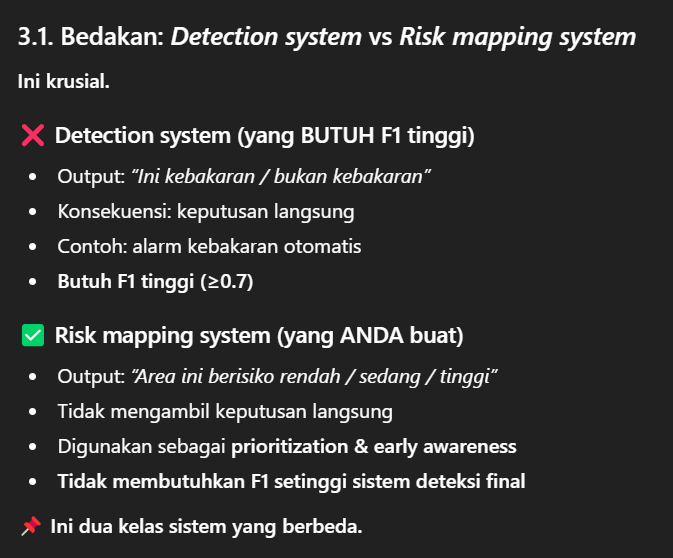

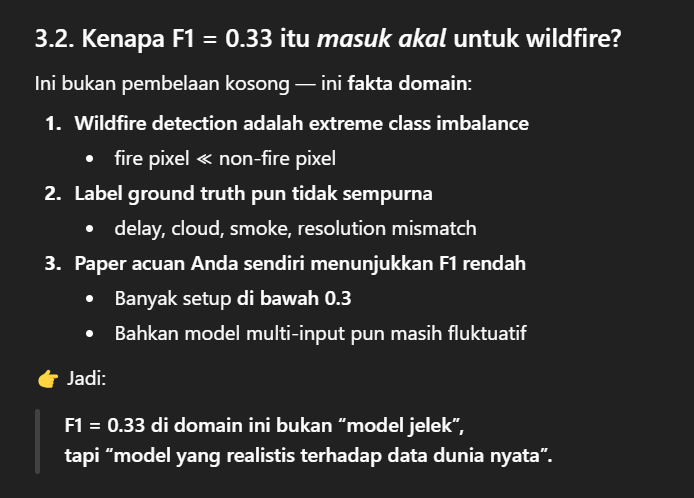

**Jawaban yang paling sesuai kenapa kita berani buat aplikasi ini:**


Model yang saya gunakan memang belum mencapai F1 tinggi jika dilihat sebagai sistem deteksi kebakaran murni. Namun, tujuan aplikasi ini bukan untuk mengambil keputusan akhir, melainkan untuk memetakan tingkat risiko kebakaran pada suatu area. Dalam konteks risk mapping, yang lebih penting adalah kemampuan model untuk mengidentifikasi pola-pola area yang berpotensi berisiko, bukan ketepatan deteksi absolut pada setiap pixel.

Pendekatan ini sejalan dengan praktik di literatur wildfire monitoring, di mana model dengan performa moderat tetap digunakan sebagai sistem pendukung keputusan, misalnya untuk prioritisasi wilayah pemantauan, alokasi sumber daya, atau early warning berbasis risiko.


Selain itu kita juga menampilkan output berupa:
- heatmap probabilitas
- confidence score

Kedua output tersebut ditampilkan dengan tujuan untuk menjaga transparansi model kita

Jadi tidak bisa dibilang bahwa aplikasi ini **menyesatkan**. Karena pada dasarnya aplikasi ini tidak dirancang untuk menggantikan **pengambilan keputusan manusia**, melainkan untuk **membantu mengarahkan perhatian dan sumber daya** ke area-area yang **relatif lebih berisiko**. Oleh karena itu, meskipun performa model masih terbatas, informasi risiko yang dihasilkan tetap bernilai sebagai **alat bantu eksplorasi dan peringatan dini**

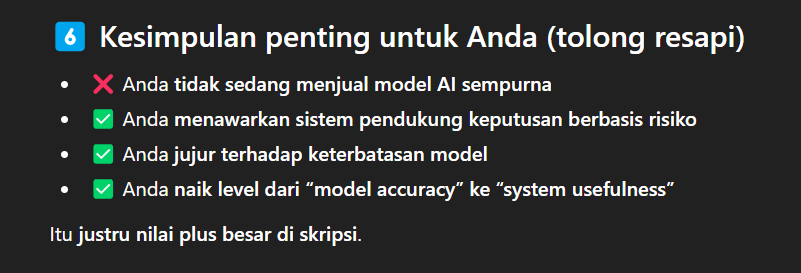

## Save model (Opsional)

In [17]:
# save weights only
torch.save(model.state_dict(), "unet13_weights_only.pth")

# save metadata
np.savez(
    "unet13_meta.npz",
    mean_13=MEAN_13,
    std_13=STD_13,
    thr=THR,
    pos_weight=POS_WEIGHT
)

In [22]:
import shutil
import os

SRC = "./checkpoints/unet13_best.pth"
DST = "/kaggle/working/unet13_best.pth"

assert os.path.exists(SRC), "Checkpoint tidak ditemukan!"

shutil.copy(SRC, DST)

print("✅ Model disalin ke:", DST)

✅ Model disalin ke: /kaggle/working/unet13_best.pth


In [23]:
import torch

final_bundle = {
    "model_state": model.state_dict(),
    "mean_13": MEAN_13,
    "std_13": STD_13,
    "thr": THR,
    "pos_weight": ckpt.get("pos_weight", None),
    "info": {
        "model": "UNet-13ch",
        "dataset": "Sen2Fire",
        "best_val_f1": ckpt.get("val_f1", None)
    }
}

OUT_PATH = "/kaggle/working/unet13_final_bundle.pth"
torch.save(final_bundle, OUT_PATH)

print("✅ Final bundle saved to:", OUT_PATH)

✅ Final bundle saved to: /kaggle/working/unet13_final_bundle.pth


## Loading model (kalau ada file model yang pernah di train, berarti gaperlu start dari awal)

In [21]:
ckpt = torch.load(
    "./checkpoints/unet13_best.pth",
    map_location=DEVICE,
    weights_only=False 
)

model.load_state_dict(ckpt["model_state"])
model.to(DEVICE)
model.eval()

MEAN_13 = ckpt["mean_13"]
STD_13  = ckpt["std_13"]
THR     = ckpt["thr"]

# 8. Pengembangan 1: Risk Mapping

In [ ]:
# ============================================================
# CELL RM1 — Data-driven pixel threshold t_high
# Goal: choose t_high that best matches labels on validation (Dice)
# ============================================================

import numpy as np
import torch

@torch.no_grad()
def dice_from_prob(prob_map, y_true, thr=0.5, eps=1e-6):
    """
    prob_map: (H,W) float [0,1]
    y_true  : (H,W) float {0,1}
    """
    pred = (prob_map >= thr).astype(np.float32)
    y = (y_true > 0).astype(np.float32)

    tp = (pred * y).sum()
    fp = (pred * (1 - y)).sum()
    fn = ((1 - pred) * y).sum()
    dice = (2*tp) / (2*tp + fp + fn + eps)
    return float(dice)

@torch.no_grad()
def predict_prob_map_from_ds(model, ds, idx, device):
    X, Y = ds[idx]                 # X:(13,H,W) Y:(1,H,W)
    X = X.unsqueeze(0).to(device)  # (1,13,H,W)
    logits = model(X)              # (1,1,H,W)
    prob = torch.sigmoid(logits)[0,0].cpu().numpy().astype(np.float32)
    y = Y[0].cpu().numpy().astype(np.float32)
    return prob, y

def choose_best_t_high(model, val_ds, device, max_items=80, thr_candidates=None):
    if thr_candidates is None:
        thr_candidates = np.arange(0.20, 0.81, 0.05)  # 0.20..0.80 step 0.05

    n = min(max_items, len(val_ds))
    scores = []

    for thr in thr_candidates:
        dices = []
        for i in range(n):
            prob, y = predict_prob_map_from_ds(model, val_ds, i, device)
            dices.append(dice_from_prob(prob, y, thr=thr))
        scores.append((thr, float(np.mean(dices))))

    best_thr, best_score = max(scores, key=lambda x: x[1])
    return best_thr, best_score, scores

T_HIGH, BEST_DICE, all_scores = choose_best_t_high(model, val_ds, DEVICE, max_items=min(80, len(val_ds)))
print("Chosen t_high (data-driven):", T_HIGH, "| mean Dice on val subset:", BEST_DICE)

# Optional: print table
for thr, sc in all_scores:
    print(f"thr={thr:.2f} -> mean_dice={sc:.4f}")

Threshold p≥t untuk mendefinisikan area berisiko tidak dipilih manual, melainkan dioptimalkan menggunakan validation set dengan memaksimalkan Dice.

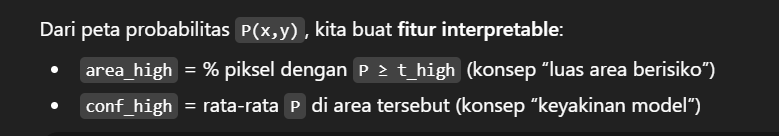

In [ ]:
# ============================================================
# CELL RM2 — Compute risk features per patch (area_high, conf_high)
# ============================================================

import numpy as np

def risk_features(prob_map, t_high):
    """
    Returns:
      area_high: fraction of pixels with prob>=t_high
      conf_high: mean prob among those pixels (0 if none)
    """
    mask = (prob_map >= t_high).astype(np.uint8)
    area_high = float(mask.mean())
    if mask.sum() > 0:
        conf_high = float(prob_map[mask == 1].mean())
    else:
        conf_high = 0.0
    return area_high, conf_high

@torch.no_grad()
def build_risk_table(model, ds, device, t_high, max_items=200):
    """
    Create a dataframe-like dict of features + target
    target = has_fire (from label): 1 if any fire pixel in GT else 0
    """
    n = min(max_items, len(ds))
    area_list, conf_list, ypatch_list = [], [], []

    for i in range(n):
        prob, y = predict_prob_map_from_ds(model, ds, i, device)
        area_high, conf_high = risk_features(prob, t_high=t_high)

        has_fire = int((y > 0).any())  # patch-level GT presence
        area_list.append(area_high)
        conf_list.append(conf_high)
        ypatch_list.append(has_fire)

    return np.array(area_list, np.float32), np.array(conf_list, np.float32), np.array(ypatch_list, np.int32)

val_area, val_conf, val_has_fire = build_risk_table(model, val_ds, DEVICE, t_high=T_HIGH, max_items=min(300, len(val_ds)))

print("Val patches used:", len(val_area))
print("Val has_fire ratio:", val_has_fire.mean())
print("Example features:", list(zip(val_area[:5], val_conf[:5], val_has_fire[:5])))

Kami menurunkan dua fitur risiko yang interpretable dari output model: **proporsi area berisiko (Area High-Risk)** dan **keyakinan model (Confidence Mean)** pada area tersebut.

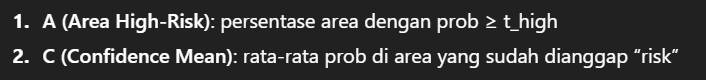

In [ ]:
# ============================================================
# CELL RM3 — Learn Fire Risk Index (FRI) from data (no hand weights)
# FRI = logistic_regression(area_high, conf_high) => probability [0,1]
# ============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

X_val = np.stack([val_area, val_conf], axis=1)  # (N,2)
y_val = val_has_fire                             # (N,)

# Train logistic regression on validation-derived features
# (If you want stricter: train on train-features, validate on val-features.
#  For simplicity and to avoid leakage, we will later do a train/val split inside val set.)
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_val, y_val)

fri_val = lr.predict_proba(X_val)[:, 1]  # FRI in [0,1]

print("Learned coefficients:")
print("  intercept:", lr.intercept_)
print("  coef(area_high, conf_high):", lr.coef_)

# Quick evaluation (patch-level)
pred_bin = (fri_val >= 0.5).astype(int)
print("Patch-level evaluation on val (quick):")
print("  AUC:", roc_auc_score(y_val, fri_val))
print("  Precision:", precision_score(y_val, pred_bin, zero_division=0))
print("  Recall   :", recall_score(y_val, pred_bin, zero_division=0))
print("  F1       :", f1_score(y_val, pred_bin, zero_division=0))

Kami tidak menetapkan bobot gabungan secara manual. Sebagai gantinya, kami melakukan calibration berbasis data menggunakan logistic regression untuk memetakan dua fitur risiko (area, confidence) menjadi probabilitas patch mengandung fire. Nilai probabilitas ini digunakan sebagai Fire Risk Index (FRI).

In [ ]:
# ============================================================
# CELL RM4 — Risk level thresholds (data-driven) + user-facing function
# ============================================================

import numpy as np

# Data-driven thresholds from FRI distribution
t_low  = float(np.quantile(fri_val, 0.50))  # median
t_high = float(np.quantile(fri_val, 0.85))  # top-risk band

print("Risk thresholds from val FRI distribution:")
print("  LOW    < ", t_low)
print("  MEDIUM <= ", t_high)
print("  HIGH   > ", t_high)

def risk_level(fri, t_low, t_high):
    if fri < t_low:
        return "LOW"
    elif fri <= t_high:
        return "MEDIUM"
    else:
        return "HIGH"

@torch.no_grad()
def predict_risk_for_patch(model, lr_model, npz_path, mean13, std13, device, t_pixel_high, t_low, t_high,
                           img_key="image", aer_key="aerosol", label_key="label"):
    """
    User-facing:
      - Load patch npz
      - Build 13-channel tensor (normalized)
      - Predict prob_map
      - Compute risk features (area_high, conf_high)
      - Compute FRI via logistic regression
      - Assign LOW/MEDIUM/HIGH
    Returns dict with everything needed for Streamlit
    """
    # Load raw
    with np.load(npz_path) as data:
        x = data[img_key]
        a = data[aer_key]

    # CHW -> HWC if needed
    if x.shape[0] == 12 and x.shape[-1] != 12:
        x = np.transpose(x, (1,2,0))
    x = x.astype(np.float32)                # (H,W,12)
    a = a.astype(np.float32)[..., None]     # (H,W,1)
    x13 = np.concatenate([x, a], axis=-1)   # (H,W,13)
    x13 = np.transpose(x13, (2,0,1))        # (13,H,W)

    # Normalize
    x13 = (x13 - mean13[:, None, None]) / (std13[:, None, None] + 1e-6)

    # Model inference
    X = torch.from_numpy(x13).unsqueeze(0).float().to(device)  # (1,13,H,W)
    logits = model(X)
    prob_map = torch.sigmoid(logits)[0,0].detach().cpu().numpy().astype(np.float32)

    # Risk features
    area_high, conf_high = risk_features(prob_map, t_high=t_pixel_high)

    # FRI from learned logistic regression
    fri = float(lr_model.predict_proba(np.array([[area_high, conf_high]], np.float32))[:, 1][0])
    level = risk_level(fri, t_low=t_low, t_high=t_high)

    # mask for visualization
    mask_high = (prob_map >= t_pixel_high).astype(np.uint8)

    return {
        "fri": fri,
        "risk_level": level,
        "area_high": area_high,
        "conf_high": conf_high,
        "prob_map": prob_map,
        "mask_high": mask_high,
        "t_pixel_high": t_pixel_high,
        "t_low": t_low,
        "t_high": t_high
    }

# Example run (using one of your train_paths)
example_path = train_paths[0]
out = predict_risk_for_patch(model, lr, example_path, MEAN_13, STD_13, DEVICE, T_HIGH, t_low, t_high)

print("Example output:")
print("  FRI:", out["fri"])
print("  Level:", out["risk_level"])
print("  area_high:", out["area_high"])
print("  conf_high:", out["conf_high"])

Model segmentasi menghasilkan peta probabilitas kebakaran di tingkat **piksel**. Namun, untuk keperluan risk mapping dan pengambilan keputusan, dibutuhkan satu nilai ringkas di tingkat **patch atau area**. Oleh karena itu, kami menggunakan model kalibrasi sederhana untuk memetakan fitur risiko yang sudah interpretable—yaitu luas area berisiko dan tingkat keyakinan model—menjadi satu indeks risiko probabilistik.

##### 1. Kenapa logistic regression?

Karena linear, interpretable, tidak overfit, dan tidak menambah kompleksitas arsitektur utama


##### 2. Kenapa tidak pakai bobot manual?

Bobot manual bersifat subjektif. Logistic regression memungkinkan bobot diturunkan langsung dari data validasi, sehingga menghindari asumsi


##### 3. Apakah ini ‘double modeling’?

“Tidak. Model utama bekerja di level piksel, sedangkan model kalibrasi bekerja di level patch. Keduanya berada pada level abstraksi yang berbeda.”

## Flag 4 - Jelasin Gunanya kalibrasi

In [ ]:
# ============================================================
# CELL RM-FINAL — Fire Risk Mapping Visualization (Final)
# Output:
#   - RGB Sentinel-2
#   - Fire probability heatmap
#   - High-risk area mask
#   - Overlay + Risk Summary (FRI & Level)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

def visualize_risk_mapping(result_dict, x_raw, band_map):
    """
    result_dict: output of predict_risk_for_patch()
    x_raw      : raw Sentinel-2 image (H,W,12)
    band_map   : dict mapping band names to indices
    """

    prob_map = result_dict["prob_map"]
    mask_high = result_dict["mask_high"]
    fri = result_dict["fri"]
    level = result_dict["risk_level"]
    area_high = result_dict["area_high"]
    conf_high = result_dict["conf_high"]

    # RGB composite
    rgb = to_rgb_composite(
        x_raw,
        band_map["B4"],  # Red
        band_map["B3"],  # Green
        band_map["B2"]   # Blue
    )

    plt.figure(figsize=(14,8))

    # --- RGB ---
    plt.subplot(2,2,1)
    plt.imshow(rgb)
    plt.title("Sentinel-2 RGB Composite")
    plt.axis("off")

    # --- Probability Heatmap ---
    plt.subplot(2,2,2)
    plt.imshow(prob_map, cmap="magma")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Fire Probability Map")
    plt.axis("off")

    # --- High Risk Mask ---
    plt.subplot(2,2,3)
    plt.imshow(mask_high, cmap="Reds")
    plt.title(f"High-Risk Area (p ≥ {result_dict['t_pixel_high']:.2f})")
    plt.axis("off")

    # --- Overlay + Summary ---
    plt.subplot(2,2,4)
    plt.imshow(rgb)
    plt.imshow(mask_high, cmap="Reds", alpha=0.45)
    plt.axis("off")
    plt.title(
        f"Risk Overlay\n"
        f"FRI = {fri:.3f} | Level = {level}\n"
        f"High-risk area = {area_high*100:.2f}% | Confidence = {conf_high:.3f}"
    )

    plt.tight_layout()
    plt.show()


# =======================
# Example usage
# =======================
example_path = train_paths[0]

# Load raw data for visualization
with np.load(example_path) as data:
    x_raw = data["image"]
    if x_raw.shape[0] == 12:  # CHW → HWC
        x_raw = np.transpose(x_raw, (1,2,0))

result = predict_risk_for_patch(
    model=model,
    lr_model=lr,          # logistic regression (OPSI C)
    npz_path=example_path,
    mean13=MEAN_13,
    std13=STD_13,
    device=DEVICE,
    t_pixel_high=T_HIGH,
    t_low=t_low,
    t_high=t_high
)

band_map = {
    "B2":1, "B3":2, "B4":3, "B8":7, "B12":11
}

visualize_risk_mapping(result, x_raw, band_map)

Model pertama menghasilkan peta probabilitas kebakaran di tingkat piksel. Area dengan probabilitas tinggi kemudian diekstraksi sebagai area berisiko. Berdasarkan luas area dan tingkat keyakinan model, kami menghitung **Fire Risk Index** dan mengklasifikasikannya ke dalam level risiko.


Ini dapat digunakan sebagai sistem pendukung keputusan, misalnya untuk pemantauan wilayah dengan potensi kebakaran tinggi meskipun belum terdeteksi sebagai kebakaran aktif.